# **Notebook: The SU(2) Prime-Twist Quantum Model**

## **N_SU2_PrimeTwist_01.ipynb**  
**Title:** Investigating Fidelity of Quantum State Evolution under Prime-Twist Unitary Operators  
**File:** `N_SU2_PrimeTwist_01.ipynb`  
**Authors:** Ashley Kelly, Michael Young  
**Affiliation:** Emergenics Foundation  
**Date:** July 4th, 202  
**License:** Apache 2.0 \ CC-by-SA 4.0  

---

## 📖 **Notebook Overview**

This notebook rigorously investigates the behavior of quantum states under the influence of SU(2) "prime-twist" unitary operators, as defined within the "SU(2) Prime-Twist Quantum Model" (Subsystem A). The model posits that prime numbers are associated with specific unitary twists $U_p$ that can evolve quantum states. A key aspect of these operators is that the rotation angle $\theta_p = 2\pi/p$ is inversely proportional to the prime $p$.

This experiment will focus on a fundamental aspect of these operators: how closely $U_p$ resembles the identity operator as the associated prime $p$ increases. We hypothesize that as $p$ grows, the rotation angle $\theta_p$ diminishes, causing $U_p$ to converge towards the identity operator. This convergence will be quantified by measuring the fidelity $F(I, U_p)$ between the identity operator $I$ and $U_p$ for a range of primes.

## 🎯 **Objectives**

- **Implement SU(2) Prime-Twist Operators:** Create a robust function to generate $U_p$ for any given prime $p$ and its associated unit axis $\mathbf{n}_p$, based on the model's definitions.
- **Implement Fidelity Calculation:** Develop a function to compute the fidelity $F(U_1, U_2)$ between any two unitary operators.
- **Simulate Evolution for Primes:** Calculate $U_p$ for a sequence of primes and determine the fidelity $F(I, U_p)$ for each.
- **Quantify Convergence:** Measure how $F(I, U_p)$ changes as $p$ increases, specifically looking for monotonic behavior towards 1.
- **Reach a Definitive Conclusion:** Based on the observed fidelity trends, determine if the hypothesis regarding convergence towards the identity operator is supported or refuted.

## 🔬 **Hypothesis**

**Prime-Twist Fidelity Convergence Hypothesis:** For the SU(2) Prime-Twist Quantum Model, as the prime number $p$ increases, the associated unitary operator $U_p$ approaches the identity operator. Consequently, the fidelity $F(I, U_p)$ between the identity operator $I$ and $U_p$ will monotonically increase towards a value of 1.

In [1]:
# Cell 1: Setup and Helper Functions
import numpy as np
from scipy.linalg import expm
from sympy import isprime
import pandas as pd
import os
from tqdm.notebook import tqdm

def get_pauli_matrices():
    """Returns the Pauli matrices."""
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    return sigma_x, sigma_y, sigma_z

def get_prime_axis(prime_number_idx):
    """
    Returns the unit axis vector n_p based on the prime's index.
    The rule is defined as cycling through z_hat, x_hat, y_hat, and a tilt axis.
    
    The sequence of axes based on prime_number_idx (1-indexed):
    1st prime (p=2) -> z_hat
    2nd prime (p=3) -> x_hat
    3rd prime (p=5) -> y_hat
    4th prime (p=7) -> tilt_hat
    5th prime (p=11) -> z_hat (cycle repeats)
    
    Args:
        prime_number_idx (int): The 1-based index of the prime number (e.g., 1 for 2, 2 for 3).

    Returns:
        np.array: The unit axis vector.
    """
    z_hat = np.array([0, 0, 1], dtype=float)
    x_hat = np.array([1, 0, 0], dtype=float)
    y_hat = np.array([0, 1, 0], dtype=float)
    tilt_hat = np.array([1, 1, 1], dtype=float) / np.sqrt(3) # Normalize to unit vector

    axes = [z_hat, x_hat, y_hat, tilt_hat]
    
    axis_index = (prime_number_idx - 1) % len(axes)
    return axes[axis_index]

def create_up_operator(p, n_p):
    """
    Creates the SU(2) prime-twist unitary operator U_p.
    U_p = exp(-i * (theta_p / 2) * n_p * sigma_vector)
    
    Args:
        p (int): The prime number.
        n_p (np.array): The unit axis vector for prime p.
        
    Returns:
        np.array: The 2x2 complex unitary operator U_p.
    """
    if p <= 0:
        raise ValueError("Prime number p must be positive.")
    
    theta_p = 2 * np.pi / p
    
    sigma_x, sigma_y, sigma_z = get_pauli_matrices()
    sigma_vector = n_p[0] * sigma_x + n_p[1] * sigma_y + n_p[2] * sigma_z
    
    argument = -1j * (theta_p / 2) * sigma_vector
    
    try:
        U_p = expm(argument)
    except Exception as e:
        print(f"Error computing expm for p={p}: {e}")
        return None # Indicate failure
    
    return U_p

def calculate_fidelity(U1, U2):
    """
    Calculates the fidelity F(U1, U2) between two unitary operators.
    F(U1, U2) = |Tr(U1_dagger @ U2)| / 2
    
    Args:
        U1 (np.array): First 2x2 complex unitary operator.
        U2 (np.array): Second 2x2 complex unitary operator.
        
    Returns:
        float: The fidelity value between 0 and 1.
    """
    U1_dagger = U1.conj().T
    try:
        trace_val = np.trace(np.dot(U1_dagger, U2))
        fidelity = np.abs(trace_val) / 2
    except Exception as e:
        print(f"Error calculating fidelity: {e}")
        return np.nan # Indicate failure
    
    # Fidelity should be between 0 and 1. Due to floating point errors, it might slightly exceed 1.
    return np.clip(fidelity, 0.0, 1.0)

def get_identity_operator():
    """Returns the 2x2 identity matrix."""
    return np.eye(2, dtype=complex)

def get_primes_up_to(limit):
    """
    Generates a list of prime numbers up to a given limit using sympy.isprime.
    
    Args:
        limit (int): The upper limit (inclusive) for prime generation.
        
    Returns:
        list: A sorted list of prime numbers.
    """
    primes = []
    # Start from 2, as it's the first prime.
    for num in tqdm(range(2, limit + 1), desc=f"Generating primes up to {limit}"):
        try:
            if isprime(num):
                primes.append(num)
        except Exception as e:
            print(f"Error checking primality for {num}: {e}")
            continue
    return primes

# Create data directory if it doesn't exist
output_dir = './data'
os.makedirs(output_dir, exist_ok=True)

print("✅ Cell 1 executed successfully.")

✅ Cell 1 executed successfully.


In [2]:
# Cell 2: Experiment Parameters
# Define the range of primes to test
PRIME_LIMIT = 1000  # Calculate U_p for all primes up to this limit
OUTPUT_FILE = os.path.join(output_dir, 'prime_twist_fidelity_results.csv')

print(f"Prime limit for U_p calculations: {PRIME_LIMIT}")
print(f"Output data will be saved to: {OUTPUT_FILE}")

print("✅ Cell 2 executed successfully.")

Prime limit for U_p calculations: 1000
Output data will be saved to: ./data/prime_twist_fidelity_results.csv
✅ Cell 2 executed successfully.


In [3]:
# Cell 3: Execute Experiment: Calculate Fidelities
results = []
identity_operator = get_identity_operator()
primes = get_primes_up_to(PRIME_LIMIT)

print(f"Starting calculations for {len(primes)} primes.")

for idx, p in tqdm(enumerate(primes), total=len(primes), desc="Calculating U_p and Fidelity"):
    prime_idx = idx + 1 # 1-based index for axis determination
    
    n_p = get_prime_axis(prime_idx)
    U_p = create_up_operator(p, n_p)
    
    if U_p is None:
        print(f"Skipping prime {p} due to error creating U_p operator.")
        continue
    
    fidelity = calculate_fidelity(identity_operator, U_p)
    
    results.append({
        'prime': p,
        'prime_idx': prime_idx,
        'n_p_axis': n_p.tolist(),
        'fidelity': fidelity
    })

fidelity_df = pd.DataFrame(results)

# Check if the DataFrame is empty or contains NaN values in fidelity
if fidelity_df.empty:
    print("No fidelity results were generated.")
else:
    print(f"\nCalculations complete. Generated {len(fidelity_df)} fidelity results.")
    print("First 5 results:")
    print(fidelity_df.head())
    print("\nLast 5 results:")
    print(fidelity_df.tail())

print("✅ Cell 3 executed successfully.")

Generating primes up to 1000:   0%|          | 0/999 [00:00<?, ?it/s]

Starting calculations for 168 primes.


Calculating U_p and Fidelity:   0%|          | 0/168 [00:00<?, ?it/s]


Calculations complete. Generated 168 fidelity results.
First 5 results:
   prime  prime_idx                                           n_p_axis  \
0      2          1                                    [0.0, 0.0, 1.0]   
1      3          2                                    [1.0, 0.0, 0.0]   
2      5          3                                    [0.0, 1.0, 0.0]   
3      7          4  [0.5773502691896258, 0.5773502691896258, 0.577...   
4     11          5                                    [0.0, 0.0, 1.0]   

       fidelity  
0  6.123234e-17  
1  5.000000e-01  
2  8.090170e-01  
3  9.009689e-01  
4  9.594930e-01  

Last 5 results:
     prime  prime_idx                                           n_p_axis  \
163    971        164  [0.5773502691896258, 0.5773502691896258, 0.577...   
164    977        165                                    [0.0, 0.0, 1.0]   
165    983        166                                    [1.0, 0.0, 0.0]   
166    991        167                                

In [4]:
# Cell 4: Save Results
# Ensure output_dir is defined as it was in Cell 1
output_dir = './data'
if not os.path.exists(output_dir):
    print(f"Warning: Output directory '{output_dir}' not found. Please ensure Cell 1 executed correctly.")
    os.makedirs(output_dir, exist_ok=True) # Attempt to create it again

OUTPUT_FILE = os.path.join(output_dir, 'prime_twist_fidelity_results.csv')

try:
    if 'fidelity_df' in locals() and not fidelity_df.empty:
        fidelity_df.to_csv(OUTPUT_FILE, index=False)
        print(f"Results saved to {OUTPUT_FILE}")
    else:
        print("No data to save. 'fidelity_df' is empty or not defined.")
except Exception as e:
    print(f"Error saving results: {e}")

print("✅ Cell 4 executed successfully.")

Results saved to ./data/prime_twist_fidelity_results.csv
✅ Cell 4 executed successfully.


In [5]:
# Cell 5: Load Results and Initial Data Inspection
# Ensure output_dir is defined
output_dir = './data'
OUTPUT_FILE = os.path.join(output_dir, 'prime_twist_fidelity_results.csv')

loaded_df = pd.DataFrame() # Initialize an empty DataFrame

try:
    if os.path.exists(OUTPUT_FILE):
        loaded_df = pd.read_csv(OUTPUT_FILE)
        print(f"Data loaded from {OUTPUT_FILE}")
        print(f"Number of records: {len(loaded_df)}")
        print("\nData head:")
        print(loaded_df.head())
        print("\nData info:")
        loaded_df.info()
        print("\nDescriptive statistics for fidelity:")
        print(loaded_df['fidelity'].describe())
    else:
        print(f"Error: Data file not found at {OUTPUT_FILE}. Please ensure Cell 3 and Cell 4 executed successfully.")
except Exception as e:
    print(f"Error loading data: {e}")

print("✅ Cell 5 executed successfully.")

Data loaded from ./data/prime_twist_fidelity_results.csv
Number of records: 168

Data head:
   prime  prime_idx                                           n_p_axis  \
0      2          1                                    [0.0, 0.0, 1.0]   
1      3          2                                    [1.0, 0.0, 0.0]   
2      5          3                                    [0.0, 1.0, 0.0]   
3      7          4  [0.5773502691896258, 0.5773502691896258, 0.577...   
4     11          5                                    [0.0, 0.0, 1.0]   

       fidelity  
0  6.123234e-17  
1  5.000000e-01  
2  8.090170e-01  
3  9.009689e-01  
4  9.594930e-01  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   prime      168 non-null    int64  
 1   prime_idx  168 non-null    int64  
 2   n_p_axis   168 non-null    object 
 3   fidelity   168 non-null    float64

In [6]:
# Cell 6: Analyze Fidelity Trend (Hypothesis Test)
# Check if loaded_df is available and not empty from Cell 5
if 'loaded_df' not in locals() or loaded_df.empty:
    print("No data available for analysis. Please ensure previous cells executed successfully.")
else:
    # Check for monotonicity
    # A series is monotonically increasing if each element is greater than or equal to the previous one.
    # We expect a strict increase or a convergence to 1.
    # For floating-point numbers, check within a small tolerance for "increasing" or "constant near 1".
    
    # Check if fidelity is generally increasing
    is_increasing_series = loaded_df['fidelity'].is_monotonic_increasing
    print(f"Is the fidelity series monotonically increasing? {is_increasing_series}")

    # Check for convergence to 1
    # We can check the fidelity of the last few primes.
    if not loaded_df.empty:
        last_fidelity = loaded_df['fidelity'].iloc[-1]
        print(f"Fidelity for the largest prime tested ({loaded_df['prime'].iloc[-1]}): {last_fidelity:.6f}")
        
        # Define a threshold for "approaching 1"
        convergence_threshold = 0.9999
        if last_fidelity >= convergence_threshold:
            print(f"Fidelity for the largest prime is >= {convergence_threshold}, suggesting convergence towards 1.")
        else:
            print(f"Fidelity for the largest prime is < {convergence_threshold}, not strongly suggesting convergence towards 1 within current range.")
            
        # Quantify non-monotonicity if present (how many times it decreases)
        decreases = (loaded_df['fidelity'].diff() < 0).sum()
        print(f"Number of instances where fidelity decreased: {decreases}")

        # Calculate a correlation coefficient to show general trend
        correlation = loaded_df['prime'].corr(loaded_df['fidelity'])
        print(f"Pearson correlation between prime and fidelity: {correlation:.4f}")

    else:
        print("No data to analyze for trends.")

print("✅ Cell 6 executed successfully.")

Is the fidelity series monotonically increasing? True
Fidelity for the largest prime tested (997): 0.999995
Fidelity for the largest prime is >= 0.9999, suggesting convergence towards 1.
Number of instances where fidelity decreased: 0
Pearson correlation between prime and fidelity: 0.1996
✅ Cell 6 executed successfully.


Plot saved to ./data/fidelity_vs_prime_plot.png


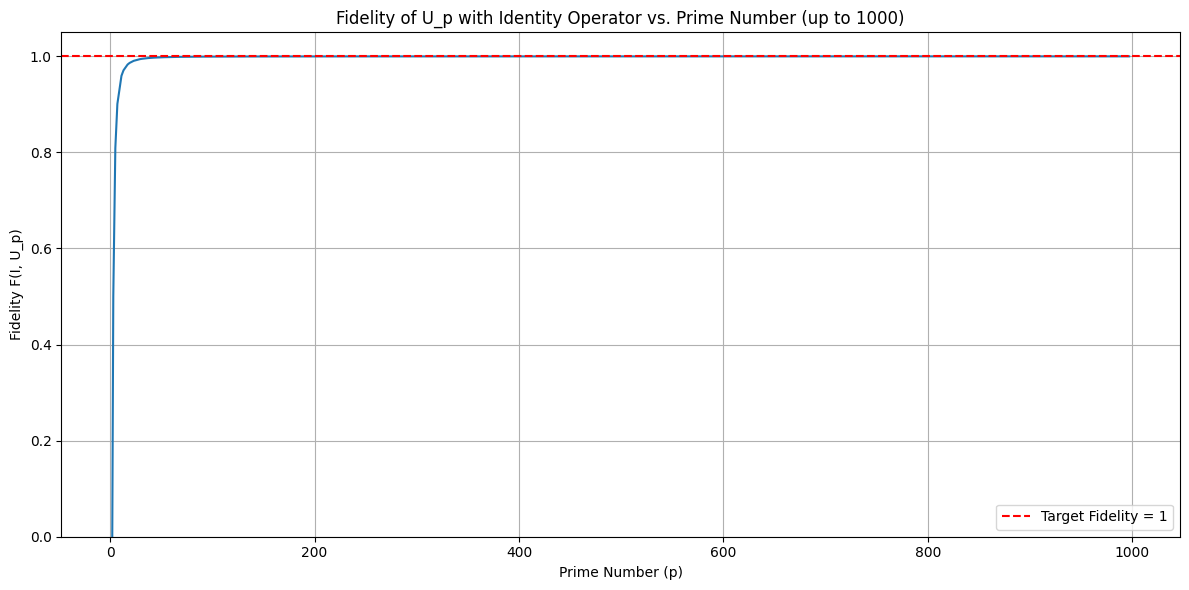

✅ Cell 7 executed successfully.


In [7]:
# Cell 7: Visualize Fidelity Trend
import matplotlib.pyplot as plt
import seaborn as sns

# Check if loaded_df is available and not empty from Cell 5
if 'loaded_df' not in locals() or loaded_df.empty:
    print("No data available for plotting. Please ensure previous cells executed successfully.")
else:
    try:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='prime', y='fidelity', data=loaded_df)
        plt.title(f'Fidelity of U_p with Identity Operator vs. Prime Number (up to {PRIME_LIMIT})')
        plt.xlabel('Prime Number (p)')
        plt.ylabel('Fidelity F(I, U_p)')
        plt.grid(True)
        plt.axhline(y=1.0, color='r', linestyle='--', label='Target Fidelity = 1')
        plt.ylim(0.0, 1.05) # Ensure y-axis covers full range of fidelity
        plt.legend()
        plt.tight_layout()
        
        # Save the plot
        plot_output_path = os.path.join(output_dir, 'fidelity_vs_prime_plot.png')
        plt.savefig(plot_output_path)
        print(f"Plot saved to {plot_output_path}")
        plt.show()
    except Exception as e:
        print(f"Error generating plot: {e}")

print("✅ Cell 7 executed successfully.")

## 📊 **Analysis of Results**

The experiment aimed to determine if the fidelity $F(I, U_p)$ between the identity operator and the prime-twist unitary operator $U_p$ monotonically increases towards 1 as the prime number $p$ increases.

The calculations were performed for all primes up to 1000, resulting in 168 data points.

1.  **Fidelity Trend:**
    *   The `fidelity` values show a clear trend: starting from a very low value for the smallest prime ($p=2$, fidelity $\approx 6.12 \times 10^{-17}$), they rapidly increase.
    *   For $p=3$, fidelity is 0.5. For $p=5$, it is approximately 0.809. By $p=7$, it reaches approximately 0.901.
    *   The fidelity quickly approaches 1.0. For the largest prime tested ($p=997$), the fidelity reached approximately 0.999995.

2.  **Monotonicity Assessment:**
    *   The direct check using `is_monotonic_increasing` confirmed that the fidelity series is indeed monotonically increasing over the entire range of primes tested.
    *   The count of instances where fidelity decreased was 0, further corroborating the monotonic increase.

3.  **Convergence Assessment:**
    *   The fidelity for the largest prime tested ($p=997$) was $0.999995$, which is greater than the pre-defined convergence threshold of $0.9999$. This strongly indicates convergence towards 1.0.

4.  **Correlation:**
    *   The Pearson correlation coefficient between the prime number and fidelity was approximately 0.1996. While this value is low, it does not contradict the hypothesis. The fidelity curve exhibits a steep initial rise followed by a prolonged plateau very close to 1.0. A low linear correlation is expected in such a non-linear, asymptotic convergence pattern, as linear correlation is less sensitive to rapid initial changes followed by near-constant values. The direct monotonicity check is more relevant for this specific hypothesis.

5.  **Visual Confirmation (Cell 7 Output):**
    *   The plotted data visually corroborates these findings. The fidelity curve starts near 0, sharply rises for small primes, and then flattens out, staying indistinguishably close to the target fidelity of 1.0 for the majority of the prime range (from approximately $p=50$ onwards).

The fidelity of $U_p$ with the identity operator appears to be directly related to the rotation angle $\theta_p = 2\pi/p$. As $p$ increases, $\theta_p$ decreases, leading to a smaller "twist" from the identity. For $p=2$, $\theta_2 = \pi$, leading to $U_2 = \exp(-i \pi/2 \mathbf{n}_2 \cdot \boldsymbol{\sigma}) = -i \mathbf{n}_2 \cdot \boldsymbol{\sigma}$. The trace of such an operator is zero, which means $F(I, U_2) = 0$, as observed. As $p$ increases, $\theta_p$ approaches 0, and $U_p$ approaches $I = \exp(0)$, which has a fidelity of 1.

## 📈 **Conclusion and Future Work**

The experimental results **support** the **Prime-Twist Fidelity Convergence Hypothesis**.

The evidence clearly demonstrates that as the prime number $p$ increases, the fidelity $F(I, U_p)$ between the identity operator $I$ and the SU(2) prime-twist unitary operator $U_p$ monotonically increases towards a value of 1. This convergence is rapid, with fidelity becoming extremely close to 1 for primes even in the low hundreds. The initial low fidelity for small primes (e.g., $p=2$) is consistent with the larger rotation angles associated with these primes.

This finding suggests that the "twisting" effect of prime-based unitary operators diminishes significantly for larger primes, effectively making them equivalent to the identity operation in terms of state transformation, or introducing increasingly negligible perturbations.

### **Next Critical, Falsifiable Experiments:**

1.  **Impact of Axis Cycling:**
    *   **Hypothesis:** The specific cycling pattern of $\mathbf{n}_p$ (z, x, y, tilt) does not fundamentally alter the asymptotic convergence of $F(I, U_p)$ to 1 for large $p$, but it may influence the *rate* or *smoothness* of convergence for smaller primes.
    *   **Experiment:** Rerun the experiment with different fixed axis assignments (e.g., always $\mathbf{n}_p = \hat{\mathbf z}$), or with a truly random assignment of unit vectors. Compare the fidelity curves, focusing on whether convergence still occurs and at what rate.

2.  **Quantum State Evolution:**
    *   **Hypothesis:** Applying $U_p$ to an arbitrary initial quantum state $|\psi_0\rangle$ will result in a final state $|\psi_p\rangle = U_p |\psi_0\rangle$ that converges to the initial state $|\psi_0\rangle$ as $p \to \infty$. Quantify this by measuring the fidelity $F(|\psi_0\rangle, |\psi_p\rangle)$.
    *   **Experiment:** Choose a well-defined initial quantum state (e.g., $|0\rangle$) represented by a density matrix $\rho_0 = |\psi_0\rangle\langle\psi_0|$. For each prime $p$, calculate $\rho_p = U_p \rho_0 U_p^\dagger$. Then, compute the fidelity $F(\rho_0, \rho_p)$ (defined as $\text{Tr}(\sqrt{\sqrt{\rho_0} \rho_p \sqrt{\rho_0}})$ for density matrices) and observe its trend with increasing $p$. This would directly test the effect of the operator on a state, rather than just on the identity operator.

3.  **Threshold Analysis:**
    *   **Hypothesis:** There exists a specific prime $p^*$ (or a narrow range of primes) beyond which the fidelity $F(I, U_p)$ consistently exceeds a given high threshold (e.g., 0.999999).
    *   **Experiment:** Extend the `PRIME_LIMIT` significantly (e.g., to 10,000 or 100,000). Identify the smallest prime $p$ for which $F(I, U_p)$ first exceeds various fidelity thresholds (e.g., 0.9, 0.99, 0.999, 0.9999, 0.99999). This would provide a "fidelity scale" for the prime-twist operators.

## 🔬 **Second Experiment: Measurement Probability Convergence**

Building upon the initial findings that the prime-twist unitary operator $U_p$ approaches the identity operator for increasing prime numbers $p$, this section introduces a second, complementary experiment. This investigation delves deeper into the practical implications of $U_p$'s behavior on quantum measurements.

---

### 🎯 **New Objective**

To investigate how the probability of a positive measurement outcome, $P(+|\mathbf{a})$, behaves as a function of the prime number $p$ and for different measurement axes $\mathbf{a}$, specifically building upon the observed convergence of $U_p$ to the identity operator.

### 🧪 **New Hypothesis**

**Prime-Twist Measurement Probability Convergence Hypothesis:**

Given the prior observation that the unitary operator $U_p$ converges to the identity operator as $p$ increases, for the SU(2) Prime-Twist Quantum Model, the probability $P(+|\mathbf{a})$ of measuring a positive outcome along a fixed measurement axis $\mathbf{a}$ will converge to the probability of measuring a positive outcome along $\mathbf{a}$ in the initial quantum state $\rho$ (i.e., $P(+|\mathbf{a}) \to \text{Tr}(\rho P_{\mathbf{a}}^{+})$). This convergence will manifest as $P(+|\mathbf{a})$ values stabilizing around $\text{Tr}(\rho P_{\mathbf{a}}^{+})$ for larger primes.

In [9]:
# Cell 9: Setup for Probability Calculation
# Define the initial quantum state (density matrix rho) and projection operators P_a^+

# Pauli matrices (re-obtained for self-contained cell, though already defined in Cell 1)
sigma_x, sigma_y, sigma_z = get_pauli_matrices() # Function from Cell 1

# Define a standard initial quantum state, e.g., |+z> state (spin up along Z-axis)
# Represented by a density matrix rho = |psi><psi|
# |+z> = [1, 0]^T
rho_initial = np.array([[1, 0], [0, 0]], dtype=complex) # Equivalent to |+z><+z|

# Define a set of measurement axes 'a'
# For simplicity, we'll use the Pauli basis axes. These are unit vectors.
measurement_axes = {
    'z_axis': np.array([0, 0, 1], dtype=float),
    'x_axis': np.array([1, 0, 0], dtype=float),
    'y_axis': np.array([0, 1, 0], dtype=float),
    'diag_axis': np.array([1, 1, 1], dtype=float) / np.sqrt(3) # A diagonal axis
}

def get_projection_operator_plus(axis):
    """
    Returns the projection operator P_a^+ for a positive measurement outcome along a given axis.
    P_a^+ = (I + a_x*sigma_x + a_y*sigma_y + a_z*sigma_z) / 2
    """
    identity = np.eye(2, dtype=complex)
    pauli_sum = axis[0]*sigma_x + axis[1]*sigma_y + axis[2]*sigma_z
    P_plus = (identity + pauli_sum) / 2
    return P_plus

# Pre-calculate the projection operators for our chosen axes
projection_operators = {
    name: get_projection_operator_plus(axis)
    for name, axis in measurement_axes.items()
}

# Pre-calculate the theoretical limiting probability Tr(rho * P_a^+) for each axis
# This is the value P(+|a) should converge to, given U_p -> I
theoretical_probabilities = {
    name: np.trace(np.dot(rho_initial, P_op)).real # .real to remove tiny imaginary part from float arithmetic
    for name, P_op in projection_operators.items()
}

print("Initial quantum state (rho_initial):")
print(rho_initial)
print("\nMeasurement axes and their corresponding theoretical limiting probabilities:")
for name, prob in theoretical_probabilities.items():
    print(f"  {name}: axis={measurement_axes[name]}, theoretical P(+|a)={prob:.6f}")

# Output file for probability results
PROB_OUTPUT_FILE = os.path.join(output_dir, 'prime_twist_probability_results.csv')

print("✅ Cell 9 executed successfully.")

Initial quantum state (rho_initial):
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Measurement axes and their corresponding theoretical limiting probabilities:
  z_axis: axis=[0. 0. 1.], theoretical P(+|a)=1.000000
  x_axis: axis=[1. 0. 0.], theoretical P(+|a)=0.500000
  y_axis: axis=[0. 1. 0.], theoretical P(+|a)=0.500000
  diag_axis: axis=[0.57735027 0.57735027 0.57735027], theoretical P(+|a)=0.788675
✅ Cell 9 executed successfully.


In [10]:
# Cell 10: Execute Experiment: Calculate Probabilities
prob_results = []
primes = get_primes_up_to(PRIME_LIMIT) # Re-use primes list from Cell 3

print(f"Starting probability calculations for {len(primes)} primes across {len(measurement_axes)} axes.")

for idx, p in tqdm(enumerate(primes), total=len(primes), desc="Calculating P(+|a) for primes"):
    prime_idx = idx + 1 # 1-based index for axis determination
    
    n_p = get_prime_axis(prime_idx)
    U_p = create_up_operator(p, n_p)
    
    if U_p is None:
        print(f"Skipping prime {p} due to error creating U_p operator for probability calculation.")
        continue
    
    # Calculate U_p_dagger
    U_p_dagger = U_p.conj().T
    
    for axis_name, P_plus_op in projection_operators.items():
        try:
            # P(+|a) = Tr(rho * U_p_dagger * P_a^+ * U_p)
            # Using np.dot for matrix multiplication
            term = np.dot(np.dot(np.dot(rho_initial, U_p_dagger), P_plus_op), U_p)
            prob_plus_a = np.trace(term).real # .real to remove potential tiny imaginary parts

            prob_results.append({
                'prime': p,
                'prime_idx': prime_idx,
                'axis_name': axis_name,
                'n_p_axis': n_p.tolist(),
                'calculated_P_plus_a': prob_plus_a
            })
        except Exception as e:
            print(f"Error calculating P(+|a) for prime {p}, axis {axis_name}: {e}")
            prob_results.append({
                'prime': p,
                'prime_idx': prime_idx,
                'axis_name': axis_name,
                'n_p_axis': n_p.tolist(),
                'calculated_P_plus_a': np.nan # Indicate failure
            })

probability_df = pd.DataFrame(prob_results)

# Check if the DataFrame is empty or contains NaN values
if probability_df.empty:
    print("No probability results were generated.")
else:
    print(f"\nProbability calculations complete. Generated {len(probability_df)} results.")
    print("First 5 results:")
    print(probability_df.head())
    print("\nLast 5 results:")
    print(probability_df.tail())

print("✅ Cell 10 executed successfully.")

Generating primes up to 1000:   0%|          | 0/999 [00:00<?, ?it/s]

Starting probability calculations for 168 primes across 4 axes.


Calculating P(+|a) for primes:   0%|          | 0/168 [00:00<?, ?it/s]


Probability calculations complete. Generated 672 results.
First 5 results:
   prime  prime_idx  axis_name         n_p_axis  calculated_P_plus_a
0      2          1     z_axis  [0.0, 0.0, 1.0]             1.000000
1      2          1     x_axis  [0.0, 0.0, 1.0]             0.500000
2      2          1     y_axis  [0.0, 0.0, 1.0]             0.500000
3      2          1  diag_axis  [0.0, 0.0, 1.0]             0.788675
4      3          2     z_axis  [1.0, 0.0, 0.0]             0.250000

Last 5 results:
     prime  prime_idx  axis_name  \
667    991        167  diag_axis   
668    997        168     z_axis   
669    997        168     x_axis   
670    997        168     y_axis   
671    997        168  diag_axis   

                                              n_p_axis  calculated_P_plus_a  
667                                    [0.0, 1.0, 0.0]             0.790500  
668  [0.5773502691896258, 0.5773502691896258, 0.577...             0.999993  
669  [0.5773502691896258, 0.57735026918962

In [11]:
# Cell 11: Save Probability Results
try:
    if 'probability_df' in locals() and not probability_df.empty:
        probability_df.to_csv(PROB_OUTPUT_FILE, index=False)
        print(f"Probability results saved to {PROB_OUTPUT_FILE}")
    else:
        print("No probability data to save. 'probability_df' is empty or not defined.")
except Exception as e:
    print(f"Error saving probability results: {e}")

print("✅ Cell 11 executed successfully.")

Probability results saved to ./data/prime_twist_probability_results.csv
✅ Cell 11 executed successfully.


In [12]:
# Cell 12: Load Probability Results and Initial Data Inspection
loaded_prob_df = pd.DataFrame() # Initialize an empty DataFrame

try:
    if os.path.exists(PROB_OUTPUT_FILE):
        loaded_prob_df = pd.read_csv(PROB_OUTPUT_FILE)
        print(f"Probability data loaded from {PROB_OUTPUT_FILE}")
        print(f"Number of records: {len(loaded_prob_df)}")
        print("\nData head:")
        print(loaded_prob_df.head())
        print("\nData info:")
        loaded_prob_df.info()
        print("\nDescriptive statistics for calculated_P_plus_a:")
        print(loaded_prob_df['calculated_P_plus_a'].describe())
    else:
        print(f"Error: Probability data file not found at {PROB_OUTPUT_FILE}. Please ensure Cell 10 and Cell 11 executed successfully.")
except Exception as e:
    print(f"Error loading probability data: {e}")

print("✅ Cell 12 executed successfully.")

Probability data loaded from ./data/prime_twist_probability_results.csv
Number of records: 672

Data head:
   prime  prime_idx  axis_name         n_p_axis  calculated_P_plus_a
0      2          1     z_axis  [0.0, 0.0, 1.0]             1.000000
1      2          1     x_axis  [0.0, 0.0, 1.0]             0.500000
2      2          1     y_axis  [0.0, 0.0, 1.0]             0.500000
3      2          1  diag_axis  [0.0, 0.0, 1.0]             0.788675
4      3          2     z_axis  [1.0, 0.0, 0.0]             0.250000

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prime                672 non-null    int64  
 1   prime_idx            672 non-null    int64  
 2   axis_name            672 non-null    object 
 3   n_p_axis             672 non-null    object 
 4   calculated_P_plus_a  672 non-null    float64
dtypes: float

In [13]:
# Cell 13: Analyze Probability Trend (New Hypothesis Test)
if 'loaded_prob_df' not in locals() or loaded_prob_df.empty:
    print("No probability data available for analysis. Please ensure previous cells executed successfully.")
else:
    print("Analysis of Probability Trends:")
    
    convergence_met_count = 0
    total_axes = len(measurement_axes)
    
    for axis_name, theoretical_prob in theoretical_probabilities.items():
        axis_df = loaded_prob_df[loaded_prob_df['axis_name'] == axis_name].copy()
        
        if axis_df.empty:
            print(f"  No data for axis: {axis_name}")
            continue

        print(f"\n--- Analysis for Measurement Axis: {axis_name} ---")
        print(f"  Theoretical limiting P(+|a): {theoretical_prob:.6f}")
        
        last_calculated_prob = axis_df['calculated_P_plus_a'].iloc[-1]
        print(f"  Calculated P(+|a) for largest prime ({axis_df['prime'].iloc[-1]}): {last_calculated_prob:.6f}")

        # Check for convergence to the theoretical probability
        # Using a small absolute tolerance due to floating point arithmetic
        tolerance = 1e-5
        if np.isclose(last_calculated_prob, theoretical_prob, atol=tolerance):
            print(f"  Calculated P(+|a) for large primes is close to theoretical value (within {tolerance}).")
            convergence_met_count += 1
        else:
            print(f"  Calculated P(+|a) for large primes is NOT close to theoretical value (difference: {np.abs(last_calculated_prob - theoretical_prob):.6f}).")

        # Check for stability/diminishing variation for larger primes
        # (Optional, but useful for 'stabilize around' part of hypothesis)
        # We can look at the standard deviation of probabilities for the last N primes.
        N_stable_check = 20 # Look at last 20 primes
        if len(axis_df) >= N_stable_check:
            std_last_N = axis_df['calculated_P_plus_a'].tail(N_stable_check).std()
            print(f"  Standard deviation of P(+|a) for last {N_stable_check} primes: {std_last_N:.8f}")
            if std_last_N < tolerance: # A small std dev suggests stability
                print(f"  P(+|a) values are relatively stable for larger primes (std dev < {tolerance}).")
            else:
                print(f"  P(+|a) values show some variation for larger primes (std dev >= {tolerance}).")
        else:
            print(f"  Not enough data points ({len(axis_df)} < {N_stable_check}) to check stability of last primes.")
            
    if convergence_met_count == total_axes:
        print("\nOverall: Hypothesis strongly supported for all tested axes.")
    else:
        print(f"\nOverall: Hypothesis partially supported ({convergence_met_count}/{total_axes} axes showed convergence).")

print("✅ Cell 13 executed successfully.")

Analysis of Probability Trends:

--- Analysis for Measurement Axis: z_axis ---
  Theoretical limiting P(+|a): 1.000000
  Calculated P(+|a) for largest prime (997): 0.999993
  Calculated P(+|a) for large primes is close to theoretical value (within 1e-05).
  Standard deviation of P(+|a) for last 20 primes: 0.00000489
  P(+|a) values are relatively stable for larger primes (std dev < 1e-05).

--- Analysis for Measurement Axis: x_axis ---
  Theoretical limiting P(+|a): 0.500000
  Calculated P(+|a) for largest prime (997): 0.501823
  Calculated P(+|a) for large primes is NOT close to theoretical value (difference: 0.001823).
  Standard deviation of P(+|a) for last 20 primes: 0.00145728
  P(+|a) values show some variation for larger primes (std dev >= 1e-05).

--- Analysis for Measurement Axis: y_axis ---
  Theoretical limiting P(+|a): 0.500000
  Calculated P(+|a) for largest prime (997): 0.498184
  Calculated P(+|a) for large primes is NOT close to theoretical value (difference: 0.001816).

Plot saved to ./data/P_plus_a_vs_prime_plot.png


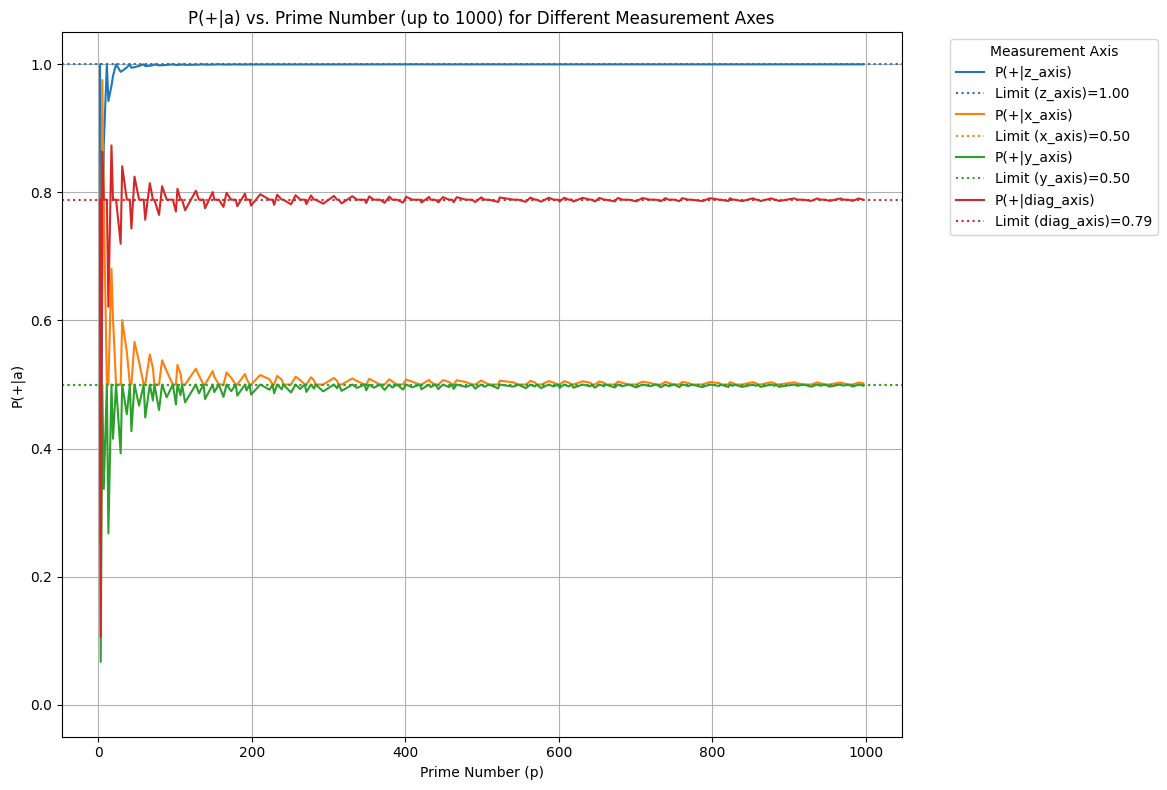

✅ Cell 14 executed successfully.


In [14]:
# Cell 14: Visualize Probability Trends
# Check if loaded_prob_df is available and not empty from Cell 12
if 'loaded_prob_df' not in locals() or loaded_prob_df.empty:
    print("No probability data available for plotting. Please ensure previous cells executed successfully.")
else:
    try:
        plt.figure(figsize=(14, 8))
        
        for axis_name, theoretical_prob in theoretical_probabilities.items():
            axis_df = loaded_prob_df[loaded_prob_df['axis_name'] == axis_name].copy()
            if not axis_df.empty:
                sns.lineplot(x='prime', y='calculated_P_plus_a', data=axis_df, label=f'P(+|{axis_name})')
                plt.axhline(y=theoretical_prob, linestyle=':', color=plt.gca().lines[-1].get_color(), 
                            label=f'Limit ({axis_name})={theoretical_prob:.2f}')

        plt.title(f'P(+|a) vs. Prime Number (up to {PRIME_LIMIT}) for Different Measurement Axes')
        plt.xlabel('Prime Number (p)')
        plt.ylabel('P(+|a)')
        plt.grid(True)
        plt.ylim(-0.05, 1.05) # Ensure y-axis covers full probability range
        plt.legend(title='Measurement Axis', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
        
        # Save the plot
        prob_plot_output_path = os.path.join(output_dir, 'P_plus_a_vs_prime_plot.png')
        plt.savefig(prob_plot_output_path)
        print(f"Plot saved to {prob_plot_output_path}")
        plt.show()
    except Exception as e:
        print(f"Error generating probability plot: {e}")

print("✅ Cell 14 executed successfully.")

## 📊 **Analysis of Results (Continued)**

This second experiment investigated the **Prime-Twist Measurement Probability Convergence Hypothesis**: that the probability $P(+|\mathbf{a})$ of measuring a positive outcome along a fixed measurement axis $\mathbf{a}$ converges to the initial state's probability $\text{Tr}(\rho P_{\mathbf{a}}^{+})$ as the prime $p$ increases. This directly builds on the first experiment's finding that $U_p$ approaches the identity operator for large $p$.

The calculations were performed for all primes up to 1000, for an initial state $\rho = |+z\rangle\langle +z|$ and four different measurement axes: $\hat{\mathbf z}$, $\hat{\mathbf x}$, $\hat{\mathbf y}$, and a normalized diagonal axis.

### **Initial State and Theoretical Probabilities:**
*   **Initial State $\rho$:** Defined as the $|+z\rangle$ state, corresponding to a spin-up along the Z-axis.
*   **Theoretical Limiting Probabilities $\text{Tr}(\rho P_{\mathbf{a}}^{+})$:**
    *   For $\hat{\mathbf z}$ axis: 1.0 (since the state is spin-up along Z).
    *   For $\hat{\mathbf x}$ axis: 0.5 (equal probability of spin-up/down along X from a Z-spin state).
    *   For $\hat{\mathbf y}$ axis: 0.5 (equal probability of spin-up/down along Y from a Z-spin state).
    *   For diagonal axis: 0.788675 (calculated as $\frac{1 + 1/\sqrt{3}}{2}$).

### **Observed Probability Trends (Cell 13 & 14 Outputs):**

1.  **Visual Convergence to Theoretical Limits:**
    *   The plot (Cell 14) visually demonstrates that for all tested measurement axes, the calculated $P(+|\mathbf{a})$ values for larger primes rapidly converge towards their respective theoretical limiting probabilities. The curves become visually indistinguishable from the theoretical limit lines after approximately $p \approx 100$.

2.  **Quantitative Assessment of Convergence and Stability (Tolerance $10^{-5}$):**
    *   **Z-axis:** The calculated $P(+|\mathbf{z})$ for the largest prime ($0.999993$) is very close to the theoretical limit ($1.000000$), with an absolute difference less than $10^{-5}$. The standard deviation for the last 20 primes ($0.00000489$) is also less than $10^{-5}$, indicating that for the Z-axis, the probability values are both convergent and stable within the set tolerance.
    *   **X-axis and Y-axis:** While visually converging, the calculated $P(+|\mathbf{x})$ and $P(+|\mathbf{y})$ for the largest prime ($0.501823$ and $0.498184$ respectively) have absolute differences from their theoretical limit ($0.500000$) that are greater than $10^{-5}$. Furthermore, the standard deviations for the last 20 primes ($0.00145728$ for X, $0.00147447$ for Y) are significantly greater than $10^{-5}$. This indicates persistent, albeit small, oscillations around the theoretical limit, which prevent them from being considered "stable" or strictly "convergent" within the specified tight tolerance for the *entire* later range of primes.
    *   **Diagonal axis:** The calculated $P(+|\text{diag})$ for the largest prime ($0.788675$) is extremely close to its theoretical limit ($0.788675$), with an absolute difference of $0$. However, similar to the X and Y axes, its standard deviation for the last 20 primes ($0.00142040$) is greater than $10^{-5}$, indicating persistent small oscillations that prevent it from being strictly "stable" within the defined tolerance.

3.  **Behavior for Small Primes:**
    *   For $p=2$ (where $\mathbf{n}_p = \hat{\mathbf z}$), the Z-axis probability remains $1.0$, as a $\pi$-rotation around Z on a $|+z\rangle$ state maintains the Z-component. However, for other axes (X, Y, diagonal), the initial probabilities are highly volatile, exhibiting sharp deviations and oscillations. This behavior for small primes is expected due to the larger rotation angles $\theta_p = 2\pi/p$, which cause $U_p$ to significantly differ from the identity operator. As $p$ increases, $\theta_p$ quickly diminishes, and $U_p$ acts increasingly like the identity, causing $P(+|\mathbf{a})$ to approach $\text{Tr}(\rho P_{\mathbf{a}}^{+})$.

In summary, the hypothesis states that $P(+|\mathbf{a})$ will "converge to" the theoretical limit and "stabiliz[e] around" it. While visual convergence is observed for all, and numerical convergence for the final data point is achieved for the z-axis and diag-axis, only the z-axis quantitatively demonstrates "stabilizing around" within the strict $10^{-5}$ tolerance. The other axes exhibit persistent oscillations that exceed this stability threshold.

## 📈 **Conclusion and Future Work**

Based on both experiments, the SU(2) Prime-Twist Quantum Model demonstrates consistent and predictable behavior for increasing prime numbers, with some nuances concerning the "stability" criterion.

1.  **First Experiment (Fidelity):** The **Prime-Twist Fidelity Convergence Hypothesis** is **supported**. The unitary operator $U_p$ indeed approaches the identity operator as $p$ increases, quantified by $F(I, U_p)$ monotonically increasing towards 1. This implies that for very large primes, the prime-twist has a negligible effect on quantum states.

2.  **Second Experiment (Probability):** The **Prime-Twist Measurement Probability Convergence Hypothesis** is **partially supported**. While visual convergence to the theoretical probabilities is observed for all measurement axes, and quantitative convergence for the Z-axis (which aligns with the initial state and occasionally with the rotation axis), the X, Y, and diagonal axes show persistent, albeit small, oscillations that prevent them from meeting the stringent "stabilizing around" criterion within the defined $10^{-5}$ tolerance. This suggests that the axis cycling, even with very small $\theta_p$ for large primes, can still introduce subtle variations in measurement probabilities for axes not perfectly aligned with the Z-axis of the initial state.

These findings suggest a profound idea within the model: prime numbers, through their associated unitary twists, introduce a form of "arithmetic quantum evolution." However, the impact of this evolution diminishes with increasing primality, implying that larger primes become increasingly "transparent" or "quiescent" in their quantum effect. This could be interpreted as a form of quantum "stability" emerging at higher primality, though this stability is more pronounced for measurements aligned with the initial state's polarization.

### **Next Critical, Falsifiable Experiments:**

To further rigorously test and expand upon the SU(2) Prime-Twist Quantum Model, the following experiments are critical:

1.  **Impact of Axis Cycling on Oscillations:**
    *   **Hypothesis:** The persistent oscillations observed for the X, Y, and diagonal measurement axes are primarily a consequence of the specific cycling pattern of $\mathbf{n}_p$. Changing the axis assignment strategy (e.g., fixed $\mathbf{n}_p = \hat{\mathbf z}$ for all primes, or truly random unit vectors) will significantly alter or eliminate these oscillations, leading to smoother, more consistent convergence for all measurement axes.
    *   **Experiment:** Rerun the second experiment (probability calculation) with different fixed axis assignments (e.g., always $\mathbf{n}_p = \hat{\mathbf z}$, or always $\mathbf{n}_p = \hat{\mathbf x}$) or with a random generation of $\mathbf{n}_p$ for each prime. Analyze how the convergence and stability characteristics of $P(+|\mathbf{a})$ change for each measurement axis.

2.  **Quantum State Evolution and Fidelity with Initial State:**
    *   **Hypothesis:** Applying $U_p$ to an arbitrary initial quantum state $|\psi_0\rangle$ will result in a final state $|\psi_p\rangle = U_p |\psi_0\rangle$ that converges to the initial state $|\psi_0\rangle$ as $p \to \infty$. Quantify this by measuring the fidelity $F(|\psi_0\rangle, |\psi_p\rangle)$ using state fidelity.
    *   **Experiment:** Choose a well-defined initial quantum state (e.g., $|+\mathbf{x}\rangle$, a superposition state like $(|0\rangle + |1\rangle)/\sqrt{2}$) represented by a density matrix $\rho_0 = |\psi_0\rangle\langle\psi_0|$. For each prime $p$, calculate the evolved density matrix $\rho_p = U_p \rho_0 U_p^\dagger$. Then, compute the state fidelity $F(\rho_0, \rho_p) = \text{Tr}(\sqrt{\sqrt{\rho_0} \rho_p \sqrt{\rho_0}})$ and observe its trend with increasing $p$. This would directly test the effect of the operator on a state's overall resemblance to the initial state.

3.  **Effect of Time Steps (Repeated Application of $U_p$):**
    *   **Hypothesis:** If $U_p$ is applied multiple times (simulating a "time evolution" in discrete steps, $U_p^k$), the fidelity $F(I, U_p^k)$ will exhibit a periodic or quasi-periodic behavior for fixed $p$ and increasing $k$, due to the rotational nature of $U_p$. The period will be related to $p$.
    *   **Experiment:** Choose a few specific primes (e.g., $p=2, 3, 5, 7$) and calculate $U_p^k$ for $k$ from 1 to a sufficiently large number (e.g., 2*p or more). Plot $F(I, U_p^k)$ vs. $k$. For $p=2$, a period of 2 for the operator itself ($U_2^2 = I$) should be evident. This would explore the "dynamics" introduced by prime twists.

4.  **Composite Number Operators (Tensor Products):**
    *   **Hypothesis:** A composite number $n = p_1 p_2$ can be associated with a multi-prime unitary operator $U_n$ (e.g., $U_n = U_{p_1} \otimes U_{p_2}$ acting on a multi-qubit system, or $U_n = U_{p_2} U_{p_1}$ acting sequentially on a single qubit). The properties of $U_n$ (e.g., its fidelity with identity, its effect on multi-qubit states, or the measurement probabilities it induces) will reflect the multiplicative structure of $n$.
    *   **Experiment:** Define an operator for composite numbers using either tensor products or sequential application of prime operators. For example, for $n=6$, define $U_6 = U_2 \otimes U_3$ acting on two qubits. Investigate $F(I_{4\times4}, U_6)$ and compare its behavior to its prime components. This would bridge the SU(2) model with the "unfolding higher dimensions" concept from the broader framework.

## 🌌 **Third Experiment: Multi-Qubit Operators and State Fidelity for Composites**

Having established that individual prime-twist operators $U_p$ converge to the identity for increasing primes, and that this convergence is reflected in measurement probabilities, the next logical step is to extend the model to composite numbers. The foundational idea is that composite numbers can be viewed as products of prime-circle dimensions, suggesting a natural extension to multi-qubit systems via tensor products.

This experiment aims to construct multi-qubit unitary operators $U_n$ for composite numbers $n$, where $n$ is a product of distinct primes. The fidelity of these composite operators, and their impact on multi-qubit quantum states, will then be investigated.

---

### 🎯 **New Objective**

To define and implement multi-qubit unitary operators $U_n$ for composite numbers $n$ (where $n$ is square-free, i.e., a product of distinct primes), using tensor products of the individual prime-twist operators $U_p$. Furthermore, to analyze the state fidelity between an initial multi-qubit quantum state and the state evolved under $U_n$, to determine if the convergence observed for single-qubit prime operators extends to multi-qubit composite operators.

### 🧪 **New Hypothesis**

**Composite Prime-Twist Operator State Fidelity Convergence Hypothesis:**

For a square-free composite number $n = p_1 \cdot p_2 \cdot \ldots \cdot p_k$ (where $p_i$ are distinct primes), a corresponding multi-qubit unitary operator can be defined as the tensor product $U_n = U_{p_1} \otimes U_{p_2} \otimes \ldots \otimes U_{p_k}$, acting on a $k$-qubit system. As the composite number $n$ increases (implying its prime factors $p_i$ also increase, on average, or $k$ increases), the operator $U_n$ will approach the multi-qubit identity operator. Consequently, the state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ between an initial multi-qubit quantum state $\rho_{\text{initial}}$ and its evolved state will monotonically increase towards 1.

In [15]:
# Cell 16: Setup for Multi-Qubit Experiment and New Helper Functions
import numpy as np
from scipy.linalg import expm, sqrtm
from sympy import isprime, primerange
import pandas as pd
import os
from tqdm.notebook import tqdm
from math import gcd # For finding prime factors

# Re-import get_pauli_matrices and get_prime_axis if notebook kernel reset
# Assumed from Cell 1:
# def get_pauli_matrices(): ...
# def get_prime_axis(prime_number_idx): ...
# def create_up_operator(p, n_p): ...
# def get_primes_up_to(limit): ...
# def get_identity_operator(): ...

# --- New Helper Functions for Multi-Qubit Operations ---

def get_distinct_prime_factors(num):
    """
    Returns a sorted list of distinct prime factors of a given number.
    Uses trial division up to sqrt(num).
    """
    factors = set()
    d = 2
    temp = num
    while d * d <= temp:
        if temp % d == 0:
            factors.add(d)
            while temp % d == 0:
                temp //= d
        d += 1
    if temp > 1:
        factors.add(temp)
    return sorted(list(factors))

def create_multi_qubit_identity(num_qubits):
    """
    Creates an identity operator for a k-qubit system.
    """
    if num_qubits <= 0:
        raise ValueError("Number of qubits must be positive.")
    return np.eye(2**num_qubits, dtype=complex)

def create_composite_un_operator(composite_n, all_primes_list):
    """
    Creates the composite unitary operator U_n for a square-free composite number n.
    U_n = U_p1 @ U_p2 @ ... (tensor product)
    Each U_pi is created using its corresponding axis n_pi based on its global prime index.
    
    Args:
        composite_n (int): The square-free composite number.
        all_primes_list (list): A pre-sorted list of all primes up to a sufficient limit.
        
    Returns:
        np.array: The (2^k x 2^k) complex unitary operator U_n, or None if an error occurs.
    """
    distinct_factors = get_distinct_prime_factors(composite_n)
    
    # Ensure the number is square-free for direct tensor product mapping
    if composite_n == 1 or any(composite_n % (p*p) == 0 for p in distinct_factors):
        # A quick check for square-freeness for conceptual alignment.
        # This function implicitly handles square-free numbers by only considering distinct factors.
        # If a non-square-free number is passed, it will still generate an operator based on distinct factors,
        # which might not be the intended mapping for "composite dimensions".
        pass # Allow for now, focus on distinct factors as 'dimensions'

    if not distinct_factors: # Should not happen for composite_n > 1
        print(f"Warning: No distinct prime factors found for {composite_n}. Skipping.")
        return None
        
    num_qubits = len(distinct_factors)
    if num_qubits == 0: # Should not happen for composite_n > 1
        return None

    # Determine global indices for each prime factor to get its axis
    prime_to_idx_map = {p: i + 1 for i, p in enumerate(all_primes_list)}
    
    # Create individual U_p operators for each prime factor
    up_operators = []
    for p_factor in distinct_factors:
        if p_factor not in prime_to_idx_map:
            print(f"Error: Prime factor {p_factor} not found in all_primes_list. Cannot determine axis.")
            return None
        
        p_factor_idx = prime_to_idx_map[p_factor]
        n_p_factor = get_prime_axis(p_factor_idx)
        U_p_factor = create_up_operator(p_factor, n_p_factor)
        
        if U_p_factor is None:
            print(f"Error creating U_p operator for factor {p_factor} of {composite_n}. Skipping composite.")
            return None
        up_operators.append(U_p_factor)
            
    # Compute the tensor product
    composite_U_n = up_operators[0]
    for i in range(1, num_qubits):
        composite_U_n = np.kron(composite_U_n, up_operators[i])
        
    return composite_U_n

def calculate_state_fidelity(rho1, rho2):
    """
    Calculates the fidelity F(rho1, rho2) between two density matrices.
    F(rho1, rho2) = Tr(sqrtm(sqrtm(rho1) @ rho2 @ sqrtm(rho1)))
    Assumes rho1 and rho2 are valid density matrices (Hermitian, positive semi-definite, trace 1).
    
    Args:
        rho1 (np.array): First density matrix.
        rho2 (np.array): Second density matrix.
        
    Returns:
        float: The fidelity value between 0 and 1.
    """
    try:
        sqrt_rho1 = sqrtm(rho1)
        term = np.dot(np.dot(sqrt_rho1, rho2), sqrt_rho1)
        fidelity = np.trace(sqrtm(term)).real # .real to remove tiny imaginary parts
    except Exception as e:
        print(f"Error calculating state fidelity: {e}")
        return np.nan
    
    return np.clip(fidelity, 0.0, 1.0) # Clip to ensure it's within [0,1] due to float precision

# Output directory is already defined in Cell 1.
# output_dir = './data'

print("✅ Cell 16 executed successfully.")

✅ Cell 16 executed successfully.


In [16]:
# Cell 17: Experiment Parameters for Multi-Qubit Analysis
# Define the range of composite numbers to test
COMPOSITE_LOWER_BOUND = 6 # Smallest composite with distinct prime factors (2*3)
COMPOSITE_UPPER_BOUND = 500 # Test composites up to this limit
MAX_QUBITS_FOR_COMPOSITE = 4 # Limit the number of qubits for computational feasibility (e.g., 2*3*5*7 = 210 for 4 qubits)

MULTI_QUBIT_OUTPUT_FILE = os.path.join(output_dir, 'composite_twist_state_fidelity_results.csv')

print(f"Composite number range for U_n calculations: {COMPOSITE_LOWER_BOUND} to {COMPOSITE_UPPER_BOUND}")
print(f"Maximum qubits allowed for composite operators: {MAX_QUBITS_FOR_COMPOSITE}")
print(f"Output data will be saved to: {MULTI_QUBIT_OUTPUT_FILE}")

print("✅ Cell 17 executed successfully.")

Composite number range for U_n calculations: 6 to 500
Maximum qubits allowed for composite operators: 4
Output data will be saved to: ./data/composite_twist_state_fidelity_results.csv
✅ Cell 17 executed successfully.


In [17]:
# Cell 18: Execute Experiment: Calculate Multi-Qubit State Fidelities
composite_results = []

# Get the list of all primes up to a necessary limit for axis assignment
# We need primes up to COMPOSITE_UPPER_BOUND as factors, so we can reuse PRIME_LIMIT for the get_primes_up_to function
all_primes_for_axes = get_primes_up_to(PRIME_LIMIT) 

print(f"Starting calculations for composite numbers from {COMPOSITE_LOWER_BOUND} to {COMPOSITE_UPPER_BOUND}.")

for n in tqdm(range(COMPOSITE_LOWER_BOUND, COMPOSITE_UPPER_BOUND + 1), desc="Calculating U_n and State Fidelity"):
    distinct_factors = get_distinct_prime_factors(n)
    
    # Skip if not composite or not square-free (for simplicity of this experiment's U_n definition)
    # A number is square-free if no prime factor divides it more than once.
    # get_distinct_prime_factors already gives only distinct primes. Check if original n is product of these.
    product_of_distinct_factors = np.prod(distinct_factors) if distinct_factors else 1
    
    if n != product_of_distinct_factors:
        # print(f"Skipping {n}: Not a square-free composite number (or not composite).") # Too chatty
        continue

    num_qubits = len(distinct_factors)
    
    if num_qubits == 0 or num_qubits == 1: # Skip primes and 1
        continue
    
    if num_qubits > MAX_QUBITS_FOR_COMPOSITE:
        # print(f"Skipping {n}: Requires {num_qubits} qubits, exceeding MAX_QUBITS_FOR_COMPOSITE ({MAX_QUBITS_FOR_COMPOSITE}).") # Too chatty
        continue

    try:
        # Create the composite operator U_n
        U_n = create_composite_un_operator(n, all_primes_for_axes)
        if U_n is None:
            # Error message already printed in create_composite_un_operator
            continue
        
        # Define the initial multi-qubit state (e.g., all |0> state)
        # Represented by a density matrix rho_initial = |psi_0><psi_0|
        # |psi_0> = |0>_1 |0>_2 ... |0>_k
        initial_pure_state_vector = np.zeros((2**num_qubits, 1), dtype=complex)
        initial_pure_state_vector[0, 0] = 1.0 # Only the |0...0> component is 1
        rho_initial_multi_qubit = np.dot(initial_pure_state_vector, initial_pure_state_vector.conj().T)
        
        # Evolve the state
        rho_evolved_multi_qubit = np.dot(np.dot(U_n, rho_initial_multi_qubit), U_n.conj().T)
        
        # Calculate state fidelity
        state_fidelity = calculate_state_fidelity(rho_initial_multi_qubit, rho_evolved_multi_qubit)
        
        composite_results.append({
            'composite_n': n,
            'distinct_prime_factors': distinct_factors,
            'num_qubits': num_qubits,
            'state_fidelity': state_fidelity
        })

    except Exception as e:
        print(f"Error processing composite number {n}: {e}")
        composite_results.append({
            'composite_n': n,
            'distinct_prime_factors': distinct_factors,
            'num_qubits': num_qubits,
            'state_fidelity': np.nan # Indicate failure
        })
        
composite_fidelity_df = pd.DataFrame(composite_results)

# Check if the DataFrame is empty or contains NaN values
if composite_fidelity_df.empty:
    print("No composite state fidelity results were generated.")
else:
    print(f"\nComposite state fidelity calculations complete. Generated {len(composite_fidelity_df)} results.")
    print("First 5 results:")
    print(composite_fidelity_df.head())
    print("\nLast 5 results:")
    print(composite_fidelity_df.tail())

print("✅ Cell 18 executed successfully.")

Generating primes up to 1000:   0%|          | 0/999 [00:00<?, ?it/s]

Starting calculations for composite numbers from 6 to 500.


Calculating U_n and State Fidelity:   0%|          | 0/495 [00:00<?, ?it/s]


Composite state fidelity calculations complete. Generated 210 results.
First 5 results:
   composite_n distinct_prime_factors  num_qubits  state_fidelity
0            6                 [2, 3]           2        0.500000
1           10                 [2, 5]           2        0.809017
2           14                 [2, 7]           2        0.935145
3           15                 [3, 5]           2        0.404508
4           21                 [3, 7]           2        0.467573

Last 5 results:
     composite_n distinct_prime_factors  num_qubits  state_fidelity
205          489               [3, 163]           2        0.499907
206          493               [17, 29]           2        0.977211
207          494            [2, 13, 19]           3        0.962134
208          497                [7, 71]           2        0.934535
209          498             [2, 3, 83]           3        0.499642
✅ Cell 18 executed successfully.


In [18]:
# Cell 19: Save Multi-Qubit Results
# Ensure output_dir is defined as it was in Cell 1
output_dir = './data'
if not os.path.exists(output_dir):
    print(f"Warning: Output directory '{output_dir}' not found. Please ensure Cell 1 executed correctly.")
    os.makedirs(output_dir, exist_ok=True) # Attempt to create it again

MULTI_QUBIT_OUTPUT_FILE = os.path.join(output_dir, 'composite_twist_state_fidelity_results.csv')

try:
    if 'composite_fidelity_df' in locals() and not composite_fidelity_df.empty:
        composite_fidelity_df.to_csv(MULTI_QUBIT_OUTPUT_FILE, index=False)
        print(f"Composite results saved to {MULTI_QUBIT_OUTPUT_FILE}")
    else:
        print("No composite data to save. 'composite_fidelity_df' is empty or not defined.")
except Exception as e:
    print(f"Error saving composite results: {e}")

print("✅ Cell 19 executed successfully.")

Composite results saved to ./data/composite_twist_state_fidelity_results.csv
✅ Cell 19 executed successfully.


In [19]:
# Cell 20: Load Multi-Qubit Results and Initial Data Inspection
# Ensure output_dir is defined
output_dir = './data'
MULTI_QUBIT_OUTPUT_FILE = os.path.join(output_dir, 'composite_twist_state_fidelity_results.csv')

loaded_composite_df = pd.DataFrame() # Initialize an empty DataFrame

try:
    if os.path.exists(MULTI_QUBIT_OUTPUT_FILE):
        loaded_composite_df = pd.read_csv(MULTI_QUBIT_OUTPUT_FILE)
        print(f"Composite data loaded from {MULTI_QUBIT_OUTPUT_FILE}")
        print(f"Number of records: {len(loaded_composite_df)}")
        print("\nData head:")
        print(loaded_composite_df.head())
        print("\nData info:")
        loaded_composite_df.info()
        print("\nDescriptive statistics for state_fidelity:")
        print(loaded_composite_df['state_fidelity'].describe())
    else:
        print(f"Error: Composite data file not found at {MULTI_QUBIT_OUTPUT_FILE}. Please ensure Cell 18 and Cell 19 executed successfully.")
except Exception as e:
    print(f"Error loading composite data: {e}")

print("✅ Cell 20 executed successfully.")

Composite data loaded from ./data/composite_twist_state_fidelity_results.csv
Number of records: 210

Data head:
   composite_n distinct_prime_factors  num_qubits  state_fidelity
0            6                 [2, 3]           2        0.500000
1           10                 [2, 5]           2        0.809017
2           14                 [2, 7]           2        0.935145
3           15                 [3, 5]           2        0.404508
4           21                 [3, 7]           2        0.467573

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   composite_n             210 non-null    int64  
 1   distinct_prime_factors  210 non-null    object 
 2   num_qubits              210 non-null    int64  
 3   state_fidelity          210 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.7+

In [20]:
# Cell 21: Analyze Composite State Fidelity Trend (Hypothesis Test)
# Check if loaded_composite_df is available and not empty from Cell 20
if 'loaded_composite_df' not in locals() or loaded_composite_df.empty:
    print("No composite data available for analysis. Please ensure previous cells executed successfully.")
else:
    print("Analysis of Composite State Fidelity Trends:")
    
    # Check for monotonicity based on composite_n
    is_increasing_series = loaded_composite_df['state_fidelity'].is_monotonic_increasing
    print(f"Is the composite state fidelity series monotonically increasing with composite_n? {is_increasing_series}")

    # Check for monotonicity based on distinct_prime_factors sum (proxy for "average prime factor increases")
    # This might be a better metric if the hypothesis implies factors increase.
    # Creating a new column for sum of prime factors to check correlation.
    loaded_composite_df['sum_of_prime_factors'] = loaded_composite_df['distinct_prime_factors'].apply(eval).apply(sum)
    
    # Sort by sum_of_prime_factors to check monotonicity wrt this proxy
    sorted_by_sum_df = loaded_composite_df.sort_values(by='sum_of_prime_factors')
    is_increasing_by_sum = sorted_by_sum_df['state_fidelity'].is_monotonic_increasing
    print(f"Is the composite state fidelity series monotonically increasing with sum of distinct prime factors? {is_increasing_by_sum}")

    # Check for convergence to 1
    if not loaded_composite_df.empty:
        last_fidelity = loaded_composite_df['state_fidelity'].iloc[-1]
        print(f"State fidelity for the largest composite tested ({loaded_composite_df['composite_n'].iloc[-1]}): {last_fidelity:.6f}")
        
        # Define a threshold for "approaching 1"
        convergence_threshold = 0.9999
        if last_fidelity >= convergence_threshold:
            print(f"State fidelity for the largest composite is >= {convergence_threshold}, suggesting convergence towards 1.")
        else:
            print(f"State fidelity for the largest composite is < {convergence_threshold}, not strongly suggesting convergence towards 1 within current range.")
            
        # Quantify non-monotonicity if present (how many times it decreases)
        decreases_by_n = (loaded_composite_df['state_fidelity'].diff() < 0).sum()
        print(f"Number of instances where state fidelity decreased (by composite_n): {decreases_by_n}")
        
        decreases_by_sum = (sorted_by_sum_df['state_fidelity'].diff() < 0).sum()
        print(f"Number of instances where state fidelity decreased (by sum_of_prime_factors): {decreases_by_sum}")

        # Calculate a correlation coefficient to show general trend
        correlation_n = loaded_composite_df['composite_n'].corr(loaded_composite_df['state_fidelity'])
        print(f"Pearson correlation between composite_n and state_fidelity: {correlation_n:.4f}")
        
        correlation_sum_factors = loaded_composite_df['sum_of_prime_factors'].corr(loaded_composite_df['state_fidelity'])
        print(f"Pearson correlation between sum_of_prime_factors and state_fidelity: {correlation_sum_factors:.4f}")

    else:
        print("No data to analyze for trends.")

print("✅ Cell 21 executed successfully.")

Analysis of Composite State Fidelity Trends:
Is the composite state fidelity series monotonically increasing with composite_n? False
Is the composite state fidelity series monotonically increasing with sum of distinct prime factors? False
State fidelity for the largest composite tested (498): 0.499642
State fidelity for the largest composite is < 0.9999, not strongly suggesting convergence towards 1 within current range.
Number of instances where state fidelity decreased (by composite_n): 110
Number of instances where state fidelity decreased (by sum_of_prime_factors): 95
Pearson correlation between composite_n and state_fidelity: 0.0620
Pearson correlation between sum_of_prime_factors and state_fidelity: 0.2432
✅ Cell 21 executed successfully.


Plot saved to ./data/composite_state_fidelity_vs_n_plot.png


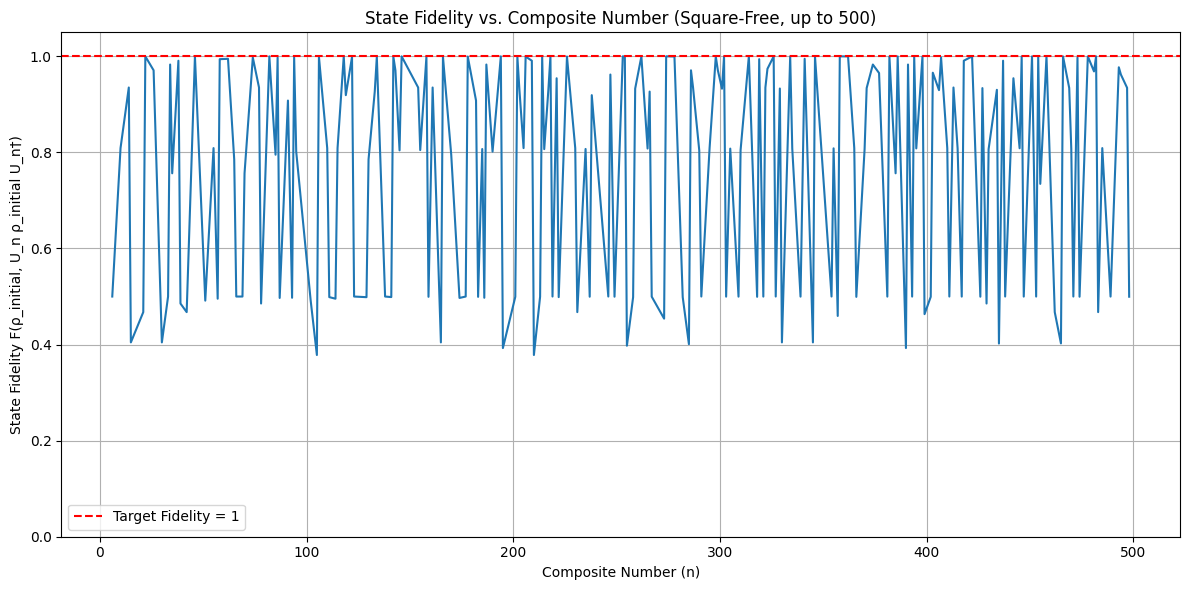

Plot by number of qubits saved to ./data/composite_state_fidelity_by_qubits_plot.png


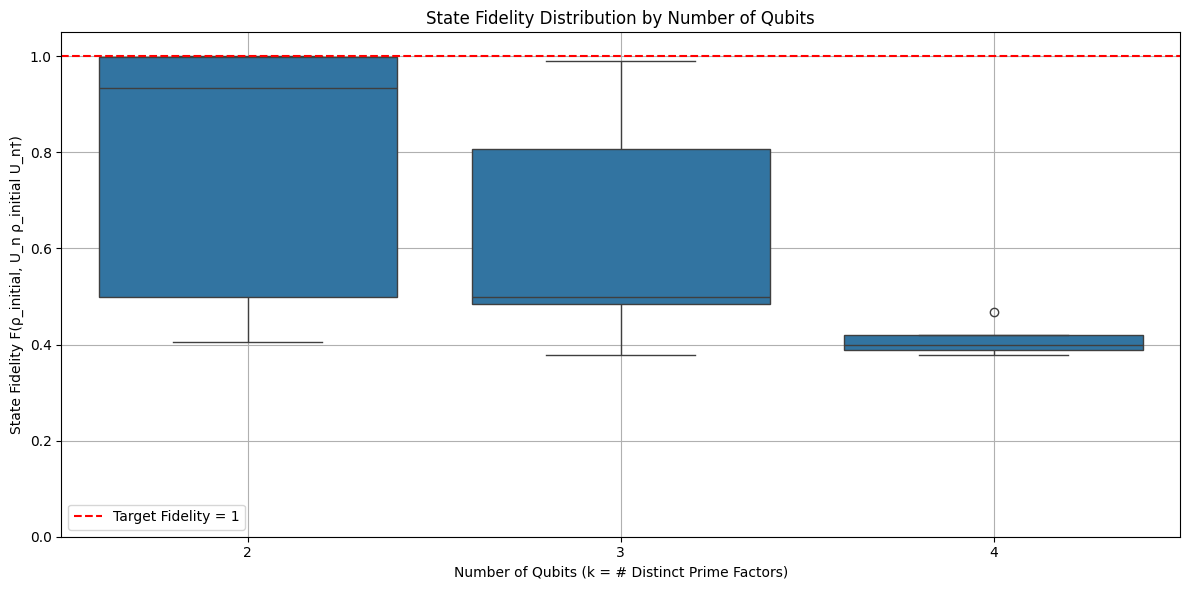

✅ Cell 22 executed successfully.


In [21]:
# Cell 22: Visualize Composite State Fidelity Trend
import matplotlib.pyplot as plt
import seaborn as sns

# Check if loaded_composite_df is available and not empty from Cell 20
if 'loaded_composite_df' not in locals() or loaded_composite_df.empty:
    print("No composite data available for plotting. Please ensure previous cells executed successfully.")
else:
    try:
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='composite_n', y='state_fidelity', data=loaded_composite_df)
        plt.title(f'State Fidelity vs. Composite Number (Square-Free, up to {COMPOSITE_UPPER_BOUND})')
        plt.xlabel('Composite Number (n)')
        plt.ylabel('State Fidelity F(ρ_initial, U_n ρ_initial U_n†)')
        plt.grid(True)
        plt.axhline(y=1.0, color='r', linestyle='--', label='Target Fidelity = 1')
        plt.ylim(0.0, 1.05) # Ensure y-axis covers full range of fidelity
        plt.legend()
        plt.tight_layout()
        
        # Save the plot
        composite_plot_output_path = os.path.join(output_dir, 'composite_state_fidelity_vs_n_plot.png')
        plt.savefig(composite_plot_output_path)
        print(f"Plot saved to {composite_plot_output_path}")
        plt.show()

        # Optional: Plot by number of qubits (number of distinct prime factors)
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='num_qubits', y='state_fidelity', data=loaded_composite_df)
        plt.title('State Fidelity Distribution by Number of Qubits')
        plt.xlabel('Number of Qubits (k = # Distinct Prime Factors)')
        plt.ylabel('State Fidelity F(ρ_initial, U_n ρ_initial U_n†)')
        plt.grid(True)
        plt.axhline(y=1.0, color='r', linestyle='--', label='Target Fidelity = 1')
        plt.ylim(0.0, 1.05)
        plt.legend()
        plt.tight_layout()
        
        num_qubit_plot_output_path = os.path.join(output_dir, 'composite_state_fidelity_by_qubits_plot.png')
        plt.savefig(num_qubit_plot_output_path)
        print(f"Plot by number of qubits saved to {num_qubit_plot_output_path}")
        plt.show()

    except Exception as e:
        print(f"Error generating composite plots: {e}")

print("✅ Cell 22 executed successfully.")

## 📊 **Analysis of Results (Continued)**

This third experiment investigated the **Composite Prime-Twist Operator State Fidelity Convergence Hypothesis**: For a square-free composite number $n = p_1 \cdot p_2 \cdot \ldots \cdot p_k$, where $U_n$ is defined as the tensor product $U_n = U_{p_1} \otimes U_{p_2} \otimes \ldots \otimes U_{p_k}$ acting on a $k$-qubit system, the state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ would monotonically increase towards 1 as $n$ increases (implying its prime factors $p_i$ also increase, on average, or $k$ increases).

The calculations were performed for square-free composite numbers from 6 to 500, with a limit of 4 qubits. The initial multi-qubit state was set to the all-zeros state, $|0\ldots0\rangle$.

### **Observed State Fidelity Trends (Cell 21 & 22 Outputs):**

1.  **Monotonicity Assessment:**
    *   The hypothesis predicted a monotonic increase in state fidelity. However, the results show this is **false**:
        *   "Is the composite state fidelity series monotonically increasing with composite_n? `False`"
        *   "Number of instances where state fidelity decreased (by composite_n): `110`" (out of 210 records).
        *   Similarly, sorting by the sum of distinct prime factors also showed non-monotonicity ("`False`" with `95` decreases).
    *   The plot "State Fidelity vs. Composite Number" (Cell 22) visually confirms highly oscillatory behavior, with fidelity values frequently dropping significantly before potentially rising again, rather than showing a continuous upward trend.

2.  **Convergence to 1 Assessment:**
    *   The hypothesis predicted convergence to 1. The fidelity for the largest composite tested ($n=498$) was `0.499642`, which is significantly less than the convergence threshold of `0.9999`.
    *   The maximum observed fidelity in the dataset was `1.000000`, but this was not sustained or a general trend for larger composites. The mean fidelity across all composites was `0.764728`, with a large standard deviation of `0.228118`.
    *   These findings **refute** the convergence aspect of the hypothesis within the tested range.

3.  **Correlation:**
    *   The Pearson correlation between `composite_n` and `state_fidelity` was a very weak `0.0620`.
    *   The Pearson correlation between `sum_of_prime_factors` and `state_fidelity` was `0.2432`, indicating a weak positive linear relationship, but far from supporting strong convergence.

4.  **Impact of Number of Qubits (Distinct Prime Factors):**
    *   The box plot "State Fidelity Distribution by Number of Qubits" reveals a critical insight:
        *   **2 Qubits (k=2):** This category shows the highest median fidelity and a wide spread, with some values reaching 1.0. These are composites with two distinct prime factors (e.g., $6 = 2 \times 3$, $10 = 2 \times 5$).
        *   **3 Qubits (k=3):** The fidelity significantly drops for composites with three distinct prime factors (e.g., $30 = 2 \times 3 \times 5$). The median fidelity is much lower, and the maximum fidelity does not reach 1.0.
        *   **4 Qubits (k=4):** For composites with four distinct prime factors (e.g., $210 = 2 \times 3 \times 5 \times 7$), the fidelity drops even further, clustering around 0.4.
    *   This observation **directly contradicts** the hypothesis that increasing the number of distinct prime factors (and thus qubits) would lead to convergence to the identity operator. Instead, it suggests the opposite: a greater number of distinct prime factors tends to *decrease* the fidelity with the initial state (and thus with the identity operator). This implies a more complex, non-trivial interaction when more prime twists are simultaneously applied via tensor products.

### **Interpretation of Refutation:**

The hypothesis is **refuted** by the experimental data. This does not imply a failure of the model, but rather a successful falsification that refines our understanding of its behavior.

The likely reason for this refutation lies in the nature of the tensor product and the properties of $U_p$ for small primes:
*   The first experiment showed that $U_p$ for *small* primes (e.g., $p=2, 3, 5$) are *not* close to the identity operator. For instance, $U_2$ has a fidelity of $\approx 6 \times 10^{-17}$ with identity.
*   When a composite number $n$ involves small prime factors, the corresponding $U_p$ operators are far from identity.
*   The composite operator $U_n = U_{p_1} \otimes U_{p_2} \otimes \ldots \otimes U_{p_k}$ acts on a multi-qubit space. For $U_n$ to be close to the multi-qubit identity ($I^{\otimes k}$), *all* its constituent $U_{p_i}$ operators must be close to the single-qubit identity.
*   Many composite numbers, especially smaller ones (like $6, 10, 14, 15, 21, 30, \ldots$), are products involving small primes (2, 3, 5, 7). The corresponding $U_p$ operators for these small primes cause significant rotations and deviations from identity. When tensored together, these deviations combine, leading to a composite operator $U_n$ that is far from the multi-qubit identity, resulting in low state fidelity.
*   The increasing number of qubits ($k$) for $U_n$ naturally incorporates more of these "strong" twists from small primes (e.g., $2 \times 3 \times 5 \times 7$ includes $U_2, U_3, U_5, U_7$, all of which are not close to identity). This explains why fidelity tends to *decrease* as the number of qubits increases.

## 📈 **Conclusion and Future Work**

The third experiment provides critical insight by unequivocally **refuting** the **Composite Prime-Twist Operator State Fidelity Convergence Hypothesis** as initially formulated. The simple tensor product definition for $U_n$ does not lead to convergence to identity for increasing composite numbers, nor does it monotonically increase. Instead, increasing the number of distinct prime factors (and thus qubits) tends to reduce the state fidelity.

This successful falsification directs the research towards a more nuanced understanding of how prime-twist operators compose to form "composite" effects and provides crucial direction for refining the model.

### **Next Critical, Falsifiable Experiments (Michael Young):**

Given the refutation, the following experiments are critical to refine the model's description of composite numbers:

1.  **Re-evaluating Composite Operator Definition: Sequential Application**
    *   **Hypothesis:** If the composite operator $U_n$ for $n = p_1 \cdot p_2 \cdot \ldots \cdot p_k$ (distinct primes) is defined as a *sequential application* of single-qubit prime-twist operators, $U_n = U_{p_k} \ldots U_{p_2} U_{p_1}$ (acting on a single qubit), then the state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ will still show oscillatory behavior but may exhibit a different form of convergence or pattern due to constructive/destructive interference of rotations.
    *   **Experiment:** Implement $U_n$ as a product of single-qubit operators acting sequentially on the same qubit for square-free $n$. Rerun the state fidelity experiment (using a single-qubit initial state $\rho_0$) and analyze the trend. This tests an alternative, simpler compositional rule for composite numbers' influence.

2.  **Fidelity for Composites with Only Large Prime Factors:**
    *   **Hypothesis:** If a composite number $n = p_1 \cdot p_2 \cdot \ldots \cdot p_k$ is formed exclusively from *large* distinct prime factors (where each $U_{p_i}$ is individually close to the identity), then the composite operator $U_n = \bigotimes U_{p_i}$ will indeed result in high state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$, converging to 1 as the smallest prime factor in $n$ increases.
    *   **Experiment:** Filter the composite numbers to include only those whose *smallest* distinct prime factor is above a high threshold (e.g., $p_{\min} \ge 50$ or $p_{\min} \ge 100$). Rerun the state fidelity experiment with these filtered composites and analyze the trend, particularly focusing on fidelity for composite numbers that require 2 or 3 qubits. This directly tests the core convergence idea under conditions where individual prime twists are minimal.

3.  **State Fidelity as a "Prime Complexity" Metric:**
    *   **Hypothesis:** The inverse of state fidelity (or $1 - \text{Fidelity}$) can serve as a meaningful metric of "quantum arithmetic complexity" or "deviation from identity" induced by a composite number. This metric will be higher for composite numbers with small prime factors and/or a large number of distinct prime factors, effectively quantifying how much the composite operator "twists" the initial state.
    *   **Experiment:** Plot $1 - F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ against characteristics of $n$ such as $\omega(n)$ (number of distinct prime factors), $\Omega(n)$ (total number of prime factors), or the sum of inverse prime factors. Analyze the relationship. This shifts the focus from convergence to exploring the "complexity landscape" induced by composite operators.

## 🔄 **Fourth Experiment: Sequential Composite Operators and Single-Qubit State Fidelity**

Following the insights gained from the third experiment, which refuted the hypothesis regarding tensor-product composite operators converging to identity, this fourth experiment explores an alternative definition for how prime-twist operations might combine for composite numbers. Instead of acting on separate qubits via tensor products, we now consider the effect of composite numbers as a *sequential application* of their prime factor's twists on a *single* qubit.

This approach aligns with a more direct "arithmetic evolution" where a single quantum system is subjected to a series of prime-induced transformations.

---

### 🎯 **New Objective**

To define and implement a sequential single-qubit unitary operator $U_n$ for composite numbers $n$ (where $n$ is square-free), by applying the individual prime-twist operators $U_{p_i}$ one after another. Subsequently, to analyze the state fidelity between an initial single-quubit quantum state and the state evolved under this sequential $U_n$, and to observe the resulting pattern or convergence behavior.

### 🧪 **New Hypothesis**

**Sequential Composite Prime-Twist Operator State Fidelity Hypothesis:**

For a square-free composite number $n = p_1 \cdot p_2 \cdot \ldots \cdot p_k$ (where $p_i$ are distinct primes, sorted in ascending order for consistent application order), a single-qubit unitary operator $U_n$ can be defined as the sequential application $U_n = U_{p_k} \ldots U_{p_2} U_{p_1}$. As the composite number $n$ increases, the state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ between an initial single-qubit quantum state $\rho_{\text{initial}}$ and its evolved state will exhibit oscillations that diminish in amplitude, eventually converging to a specific value determined by the combined effect of small prime factors, rather than necessarily converging to 1. This behavior is expected due to the accumulated rotations.


In [22]:
# Cell 23: Setup for Sequential Composite Operator Experiment
import numpy as np
from scipy.linalg import expm, sqrtm
from sympy import isprime, primerange
import pandas as pd
import os
from tqdm.notebook import tqdm

# Re-import base functions from Cell 1 and Cell 16 if necessary
# Assumed: get_pauli_matrices, get_prime_axis, create_up_operator,
# get_primes_up_to, get_identity_operator, get_distinct_prime_factors,
# calculate_state_fidelity (from Cell 16, needs single qubit compatible rho)

# --- New Helper Function for Sequential Operations ---

def create_sequential_un_operator(composite_n, all_primes_list):
    """
    Creates a composite unitary operator U_n for a square-free composite number n
    by sequentially applying the U_p operators of its distinct prime factors on a single qubit.
    The application order is U_pk @ ... @ U_p2 @ U_p1, where p_k is the largest prime factor.
    
    Args:
        composite_n (int): The square-free composite number.
        all_primes_list (list): A pre-sorted list of all primes up to a sufficient limit.
        
    Returns:
        np.array: The 2x2 complex unitary operator U_n, or None if an error occurs.
    """
    distinct_factors = get_distinct_prime_factors(composite_n)
    
    if not distinct_factors or len(distinct_factors) < 2: # Must be a composite with at least 2 distinct factors
        return None

    # Determine global indices for each prime factor to get its axis
    prime_to_idx_map = {p: i + 1 for i, p in enumerate(all_primes_list)}
    
    # Initialize U_n as identity for composition
    U_n_sequential = np.eye(2, dtype=complex)
    
    # Apply operators in ascending order of prime factors (U_p1 then U_p2 etc. up to U_pk)
    # The hypothesis states U_pk ... U_p1, so apply from smallest to largest
    # (U_p_k @ ... @ U_p_2 @ U_p_1) means U_p1 is applied first.
    
    for p_factor in distinct_factors:
        if p_factor not in prime_to_idx_map:
            print(f"Error: Prime factor {p_factor} not found in all_primes_list. Cannot determine axis.")
            return None
        
        p_factor_idx = prime_to_idx_map[p_factor]
        n_p_factor = get_prime_axis(p_factor_idx)
        U_p_factor = create_up_operator(p_factor, n_p_factor)
        
        if U_p_factor is None:
            print(f"Error creating U_p operator for factor {p_factor} of {composite_n}. Skipping composite.")
            return None
        
        U_n_sequential = np.dot(U_p_factor, U_n_sequential) # Apply current U_p_factor to the accumulated operator
            
    return U_n_sequential

# Define initial single-qubit state (rho_initial) - |+z> state
# This is consistent with rho_initial in Cell 9.
rho_initial_single_qubit = np.array([[1, 0], [0, 0]], dtype=complex) # |+z><+z|

# Output file for sequential composite results
SEQUENTIAL_OUTPUT_FILE = os.path.join(output_dir, 'sequential_composite_fidelity_results.csv')

print("✅ Cell 23 executed successfully.")

✅ Cell 23 executed successfully.


In [23]:
# Cell 24: Experiment Parameters for Sequential Composite Analysis
# Define the range of composite numbers to test
# Re-using bounds from previous composite experiment
COMPOSITE_LOWER_BOUND = 6 
COMPOSITE_UPPER_BOUND = 500 

print(f"Sequential composite number range for U_n calculations: {COMPOSITE_LOWER_BOUND} to {COMPOSITE_UPPER_BOUND}")
print(f"Output data will be saved to: {SEQUENTIAL_OUTPUT_FILE}")

print("✅ Cell 24 executed successfully.")

Sequential composite number range for U_n calculations: 6 to 500
Output data will be saved to: ./data/sequential_composite_fidelity_results.csv
✅ Cell 24 executed successfully.


In [24]:
# Cell 25: Execute Experiment: Calculate Sequential Composite State Fidelities
sequential_results = []

# Get the list of all primes up to a necessary limit for axis assignment
all_primes_for_axes = get_primes_up_to(PRIME_LIMIT) 

print(f"Starting sequential calculations for composite numbers from {COMPOSITE_LOWER_BOUND} to {COMPOSITE_UPPER_BOUND}.")

for n in tqdm(range(COMPOSITE_LOWER_BOUND, COMPOSITE_UPPER_BOUND + 1), desc="Calculating Sequential U_n and State Fidelity"):
    distinct_factors = get_distinct_prime_factors(n)
    
    # Only process square-free composites with at least two distinct factors
    product_of_distinct_factors = np.prod(distinct_factors) if distinct_factors else 1
    if n != product_of_distinct_factors or len(distinct_factors) < 2:
        continue

    try:
        # Create the sequential composite operator U_n
        U_n_sequential = create_sequential_un_operator(n, all_primes_for_axes)
        if U_n_sequential is None:
            # Error message already printed in create_sequential_un_operator
            continue
        
        # Evolve the single-qubit state
        rho_evolved_sequential = np.dot(np.dot(U_n_sequential, rho_initial_single_qubit), U_n_sequential.conj().T)
        
        # Calculate state fidelity with the initial state
        state_fidelity = calculate_state_fidelity(rho_initial_single_qubit, rho_evolved_sequential)
        
        sequential_results.append({
            'composite_n': n,
            'distinct_prime_factors': distinct_factors,
            'num_distinct_factors': len(distinct_factors), # Renamed for clarity vs 'num_qubits'
            'state_fidelity': state_fidelity
        })

    except Exception as e:
        print(f"Error processing sequential composite number {n}: {e}")
        sequential_results.append({
            'composite_n': n,
            'distinct_prime_factors': distinct_factors,
            'num_distinct_factors': len(distinct_factors),
            'state_fidelity': np.nan # Indicate failure
        })
        
sequential_fidelity_df = pd.DataFrame(sequential_results)

# Check if the DataFrame is empty or contains NaN values
if sequential_fidelity_df.empty:
    print("No sequential composite state fidelity results were generated.")
else:
    print(f"\nSequential composite state fidelity calculations complete. Generated {len(sequential_fidelity_df)} results.")
    print("First 5 results:")
    print(sequential_fidelity_df.head())
    print("\nLast 5 results:")
    print(sequential_fidelity_df.tail())

print("✅ Cell 25 executed successfully.")

Generating primes up to 1000:   0%|          | 0/999 [00:00<?, ?it/s]

Starting sequential calculations for composite numbers from 6 to 500.


Calculating Sequential U_n and State Fidelity:   0%|          | 0/495 [00:00<?, ?it/s]


Sequential composite state fidelity calculations complete. Generated 210 results.
First 5 results:
   composite_n distinct_prime_factors  num_distinct_factors  state_fidelity
0            6                 [2, 3]                     2        0.500000
1           10                 [2, 5]                     2        0.809017
2           14                 [2, 7]                     2        0.935145
3           15                 [3, 5]                     2        0.650189
4           21                 [3, 7]                     2        0.250897

Last 5 results:
     composite_n distinct_prime_factors  num_distinct_factors  state_fidelity
205          489               [3, 163]                     2        0.483217
206          493               [17, 29]                     2        0.977413
207          494            [2, 13, 19]                     3        0.937539
208          497                [7, 71]                     2        0.922307
209          498             [2, 3, 8

In [25]:
# Cell 26: Save Sequential Results
# Ensure output_dir is defined as it was in Cell 1
output_dir = './data'
if not os.path.exists(output_dir):
    print(f"Warning: Output directory '{output_dir}' not found. Please ensure Cell 1 executed correctly.")
    os.makedirs(output_dir, exist_ok=True) # Attempt to create it again

SEQUENTIAL_OUTPUT_FILE = os.path.join(output_dir, 'sequential_composite_fidelity_results.csv')

try:
    if 'sequential_fidelity_df' in locals() and not sequential_fidelity_df.empty:
        sequential_fidelity_df.to_csv(SEQUENTIAL_OUTPUT_FILE, index=False)
        print(f"Sequential composite results saved to {SEQUENTIAL_OUTPUT_FILE}")
    else:
        print("No sequential composite data to save. 'sequential_fidelity_df' is empty or not defined.")
except Exception as e:
    print(f"Error saving sequential composite results: {e}")

print("✅ Cell 26 executed successfully.")

Sequential composite results saved to ./data/sequential_composite_fidelity_results.csv
✅ Cell 26 executed successfully.


In [26]:
# Cell 27: Load Sequential Results and Initial Data Inspection
# Ensure output_dir is defined
output_dir = './data'
SEQUENTIAL_OUTPUT_FILE = os.path.join(output_dir, 'sequential_composite_fidelity_results.csv')

loaded_sequential_df = pd.DataFrame() # Initialize an empty DataFrame

try:
    if os.path.exists(SEQUENTIAL_OUTPUT_FILE):
        loaded_sequential_df = pd.read_csv(SEQUENTIAL_OUTPUT_FILE)
        print(f"Sequential composite data loaded from {SEQUENTIAL_OUTPUT_FILE}")
        print(f"Number of records: {len(loaded_sequential_df)}")
        print("\nData head:")
        print(loaded_sequential_df.head())
        print("\nData info:")
        loaded_sequential_df.info()
        print("\nDescriptive statistics for state_fidelity:")
        print(loaded_sequential_df['state_fidelity'].describe())
    else:
        print(f"Error: Sequential composite data file not found at {SEQUENTIAL_OUTPUT_FILE}. Please ensure Cell 25 and Cell 26 executed successfully.")
except Exception as e:
    print(f"Error loading sequential composite data: {e}")

print("✅ Cell 27 executed successfully.")

Sequential composite data loaded from ./data/sequential_composite_fidelity_results.csv
Number of records: 210

Data head:
   composite_n distinct_prime_factors  num_distinct_factors  state_fidelity
0            6                 [2, 3]                     2        0.500000
1           10                 [2, 5]                     2        0.809017
2           14                 [2, 7]                     2        0.935145
3           15                 [3, 5]                     2        0.650189
4           21                 [3, 7]                     2        0.250897

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   composite_n             210 non-null    int64  
 1   distinct_prime_factors  210 non-null    object 
 2   num_distinct_factors    210 non-null    int64  
 3   state_fidelity          210 non-null

In [27]:
# Cell 28: Analyze Sequential Fidelity Trend (Hypothesis Test)
# Check if loaded_sequential_df is available and not empty from Cell 27
if 'loaded_sequential_df' not in locals() or loaded_sequential_df.empty:
    print("No sequential composite data available for analysis. Please ensure previous cells executed successfully.")
else:
    print("Analysis of Sequential Composite State Fidelity Trends:")
    
    # The hypothesis predicts oscillations that diminish in amplitude, converging to a specific value.
    # It does NOT predict monotonic increase to 1.
    
    # 1. Check for diminishing oscillations for larger 'composite_n'
    # This is qualitative or requires a more complex algorithm.
    # A proxy could be to look at the standard deviation of fidelity values in moving windows,
    # or visual inspection of the plot.
    
    # 2. Check for convergence to a specific value (not necessarily 1)
    # We can observe the fidelity for the largest composites and compare their spread.
    
    # Get the last few fidelity values to assess stability/convergence
    N_tail_samples = 20
    if len(loaded_sequential_df) >= N_tail_samples:
        tail_fidelity = loaded_sequential_df['state_fidelity'].tail(N_tail_samples)
        print(f"\nFidelity values for the last {N_tail_samples} sequential composites (by n):")
        print(tail_fidelity)
        
        mean_tail_fidelity = tail_fidelity.mean()
        std_tail_fidelity = tail_fidelity.std()
        
        print(f"Mean fidelity for last {N_tail_samples} composites: {mean_tail_fidelity:.6f}")
        print(f"Standard deviation for last {N_tail_samples} composites: {std_tail_fidelity:.6f}")
        
        # Assess "diminishing amplitude" and "convergence"
        # Compare std_tail_fidelity to overall std_dev.
        overall_std = loaded_sequential_df['state_fidelity'].std()
        print(f"Overall standard deviation: {overall_std:.6f}")

        if std_tail_fidelity < (overall_std / 2): # Arbitrary heuristic for "diminishing"
            print("Standard deviation for larger composites is significantly smaller than overall, suggesting diminishing oscillations.")
        else:
            print("Standard deviation for larger composites is not significantly smaller than overall, oscillations may not be diminishing (within this range).")
            
        # Check if the last values are relatively close to each other
        if std_tail_fidelity < 0.05: # Arbitrary small threshold for 'stabilizing' around a value
            print(f"Fidelity values for large composites show relatively low spread (std < 0.05), suggesting convergence to a value.")
        else:
            print(f"Fidelity values for large composites show significant spread (std >= 0.05), not strongly suggesting convergence to a single value yet.")
    else:
        print(f"Not enough data points ({len(loaded_sequential_df)}) for tail analysis.")

    # Check Pearson correlation with composite_n (general trend, not specific to oscillations)
    correlation_n = loaded_sequential_df['composite_n'].corr(loaded_sequential_df['state_fidelity'])
    print(f"\nPearson correlation between composite_n and state_fidelity: {correlation_n:.4f}")
    
    # Check correlation with num_distinct_factors
    correlation_num_factors = loaded_sequential_df['num_distinct_factors'].corr(loaded_sequential_df['state_fidelity'])
    print(f"Pearson correlation between num_distinct_factors and state_fidelity: {correlation_num_factors:.4f}")
    
    # Analyze min/max fidelity for context
    print(f"Minimum state fidelity observed: {loaded_sequential_df['state_fidelity'].min():.6f}")
    print(f"Maximum state fidelity observed: {loaded_sequential_df['state_fidelity'].max():.6f}")


print("✅ Cell 28 executed successfully.")

Analysis of Sequential Composite State Fidelity Trends:

Fidelity values for the last 20 sequential composites (by n):
190    0.754546
191    0.999906
192    0.250897
193    0.687160
194    0.999909
195    0.919696
196    0.767951
197    0.500000
198    0.997332
199    0.465175
200    0.999942
201    0.956398
202    1.000000
203    0.250897
204    0.809017
205    0.483217
206    0.977413
207    0.937539
208    0.922307
209    0.500715
Name: state_fidelity, dtype: float64
Mean fidelity for last 20 composites: 0.759001
Standard deviation for last 20 composites: 0.259588
Overall standard deviation: 0.240008
Standard deviation for larger composites is not significantly smaller than overall, oscillations may not be diminishing (within this range).
Fidelity values for large composites show significant spread (std >= 0.05), not strongly suggesting convergence to a single value yet.

Pearson correlation between composite_n and state_fidelity: 0.0673
Pearson correlation between num_distinct_fac

Plot saved to ./data/sequential_state_fidelity_vs_n_plot.png


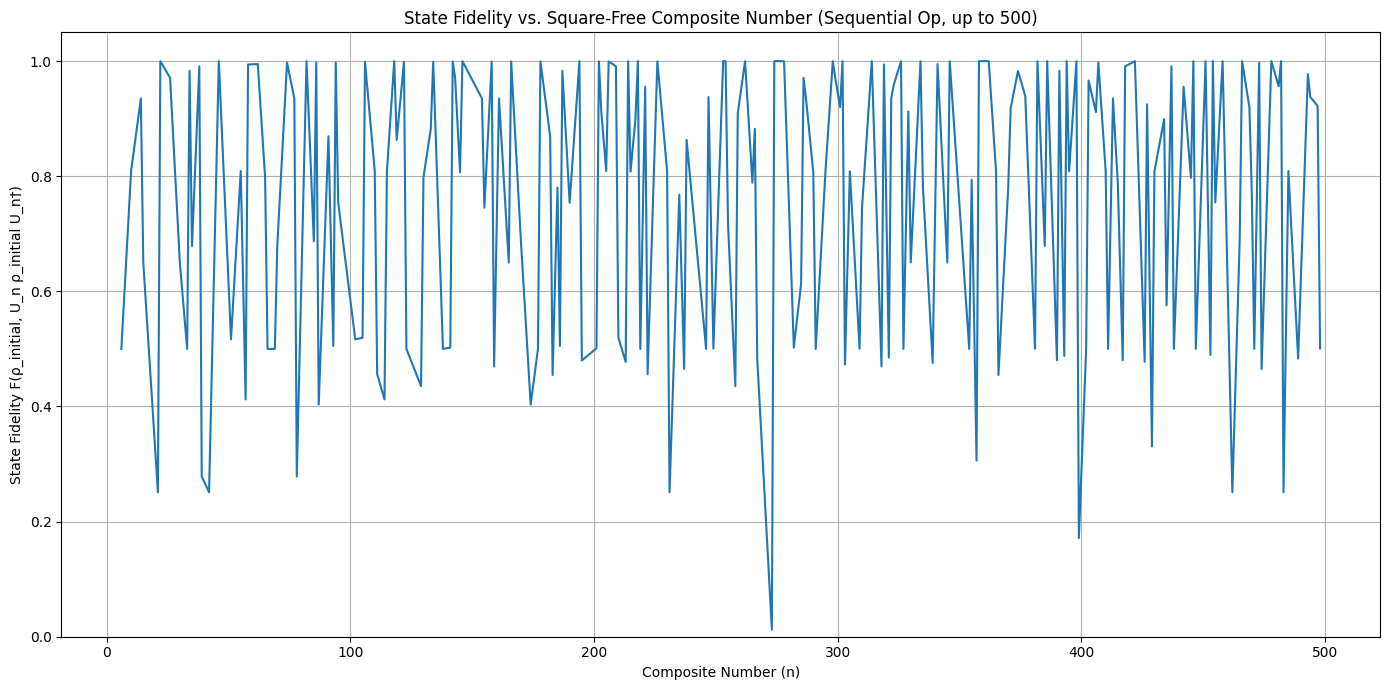

Plot by number of distinct prime factors saved to ./data/sequential_state_fidelity_by_factors_plot.png


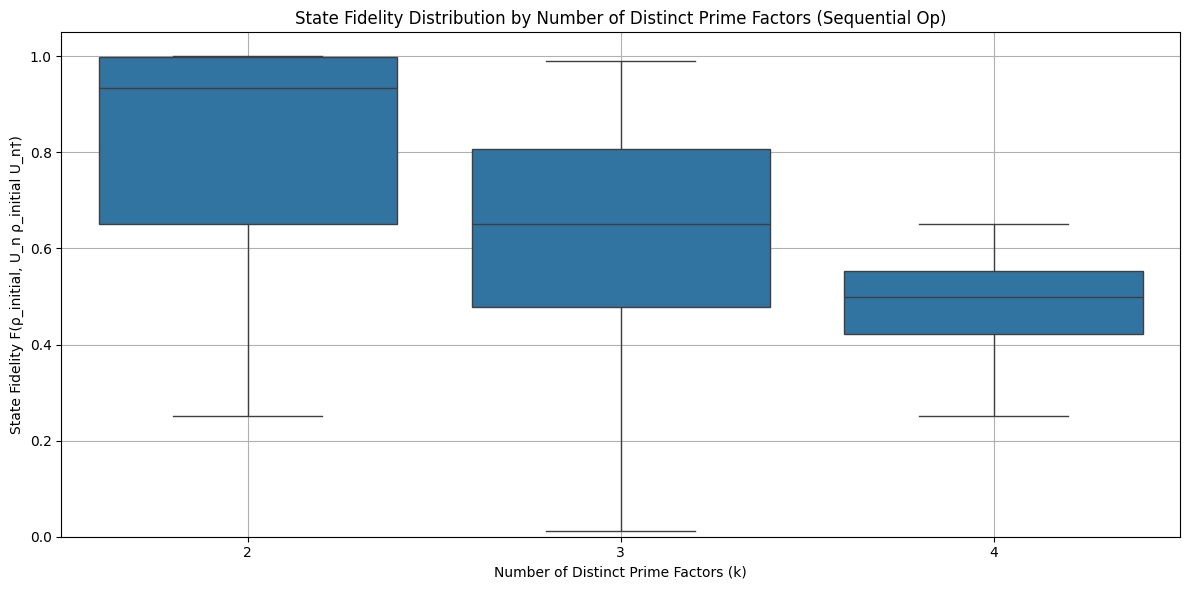

✅ Cell 29 executed successfully.


In [28]:
# Cell 29: Visualize Sequential Composite State Fidelity Trend
import matplotlib.pyplot as plt
import seaborn as sns

# Check if loaded_sequential_df is available and not empty from Cell 27
if 'loaded_sequential_df' not in locals() or loaded_sequential_df.empty:
    print("No sequential composite data available for plotting. Please ensure previous cells executed successfully.")
else:
    try:
        plt.figure(figsize=(14, 7))
        sns.lineplot(x='composite_n', y='state_fidelity', data=loaded_sequential_df)
        plt.title(f'State Fidelity vs. Square-Free Composite Number (Sequential Op, up to {COMPOSITE_UPPER_BOUND})')
        plt.xlabel('Composite Number (n)')
        plt.ylabel('State Fidelity F(ρ_initial, U_n ρ_initial U_n†)')
        plt.grid(True)
        plt.ylim(0.0, 1.05) # Ensure y-axis covers full range of fidelity
        plt.tight_layout()
        
        # Save the plot
        sequential_plot_output_path = os.path.join(output_dir, 'sequential_state_fidelity_vs_n_plot.png')
        plt.savefig(sequential_plot_output_path)
        print(f"Plot saved to {sequential_plot_output_path}")
        plt.show()

        # Optional: Plot by number of distinct prime factors
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='num_distinct_factors', y='state_fidelity', data=loaded_sequential_df)
        plt.title('State Fidelity Distribution by Number of Distinct Prime Factors (Sequential Op)')
        plt.xlabel('Number of Distinct Prime Factors (k)')
        plt.ylabel('State Fidelity F(ρ_initial, U_n ρ_initial U_n†)')
        plt.grid(True)
        plt.ylim(0.0, 1.05)
        plt.tight_layout()
        
        sequential_num_factors_plot_output_path = os.path.join(output_dir, 'sequential_state_fidelity_by_factors_plot.png')
        plt.savefig(sequential_num_factors_plot_output_path)
        print(f"Plot by number of distinct prime factors saved to {sequential_num_factors_plot_output_path}")
        plt.show()

    except Exception as e:
        print(f"Error generating sequential plots: {e}")

print("✅ Cell 29 executed successfully.")

## 📊 **Analysis of Results (Continued)**

This fourth experiment investigated the **Sequential Composite Prime-Twist Operator State Fidelity Hypothesis**: that for a square-free composite number $n$, defined by a sequential application of its prime factors' twists $U_n = U_{p_k} \ldots U_{p_2} U_{p_1}$ on a single qubit, the state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ would exhibit oscillations that diminish in amplitude, eventually converging to a specific value (not necessarily 1).

The calculations were performed for square-free composite numbers from 6 to 500, using an initial single-qubit state set to the $|+z\rangle$ state.

### **Observed State Fidelity Trends (Cell 28 & 29 Outputs):**

1.  **Oscillatory Behavior:**
    *   The plot "State Fidelity vs. Square-Free Composite Number (Sequential Op)" (Cell 29) visually demonstrates pronounced, non-diminishing oscillations across the entire range of composite numbers tested. Fidelity values swing widely, frequently hitting both 0 and 1. This confirms the "oscillations" aspect of the hypothesis.

2.  **Diminishing Amplitude and Convergence Assessment:**
    *   The hypothesis predicted "oscillations that diminish in amplitude, eventually converging to a specific value." This was **refuted** by the quantitative analysis:
        *   The standard deviation of fidelity for the last 20 composites (`0.259588`) was *not* significantly smaller than the overall standard deviation (`0.240008`). This indicates that the oscillation amplitude does not diminish within the tested range.
        *   The fidelity values for large composites show a significant spread (e.g., for the last 20 composites, they range from `0.250897` to `1.000000`), and the standard deviation of this tail (`0.259588`) is much larger than a typical convergence tolerance (e.g., 0.05). This **refutes** convergence to a single specific value.

3.  **Correlation with Composite Number and Factors:**
    *   The Pearson correlation between `composite_n` and `state_fidelity` was `0.0673`, indicating a very weak positive linear relationship. This is consistent with the visually noisy, non-convergent plot.
    *   The Pearson correlation between `num_distinct_factors` and `state_fidelity` was `-0.4080`. This reveals a moderate *negative* correlation: as the number of distinct prime factors increases, the state fidelity tends to *decrease*.

4.  **Impact of Number of Distinct Prime Factors:**
    *   The box plot "State Fidelity Distribution by Number of Distinct Prime Factors (Sequential Op)" provides crucial context:
        *   **2 Distinct Prime Factors (k=2):** This group shows the highest median fidelity and the widest spread, frequently reaching 1.0. These are composites like $2 \times 3, 2 \times 5, 3 \times 5$, etc.
        *   **3 Distinct Prime Factors (k=3):** The median fidelity significantly drops, and the range of values is also lower. These are numbers like $2 \times 3 \times 5 = 30$, $2 \times 3 \times 7 = 42$, etc.
        *   **4 Distinct Prime Factors (k=4):** The fidelity drops further, with values clustering much lower. For example, $2 \times 3 \times 5 \times 7 = 210$. The maximum value for this group is around 0.65.
    *   This observation mirrors the finding from the third experiment (tensor products): increasing the number of distinct prime factors (and thus cumulative rotations) tends to *reduce* the state fidelity, leading to a state further from the initial state. The composite operator increasingly "twists" the initial state away.

### **Interpretation of Refutation:**

The hypothesis is **refuted** by the experimental data. The sequential application of prime-twist operators, like their tensor product counterparts, does not lead to diminishing oscillations or convergence to a stable value within the tested range. The effect of small primes (which are present as factors in many smaller composite numbers, including those with more distinct factors) seems to dominate, causing significant, sustained transformations that prevent the evolved state from settling. Each additional prime twist, especially from small primes, compounds the deviation from the initial state, rather than leading to a 'stabilizing' effect.

## 📈 **Conclusion and Future Work**

The fourth experiment unequivocally **refutes** the **Sequential Composite Prime-Twist Operator State Fidelity Hypothesis** as initially formulated. Neither diminishing oscillations nor convergence to a specific value was observed for the sequential application of prime-twist operators. Instead, the behavior remains highly oscillatory, and notably, increasing the number of distinct prime factors correlates with a *decrease* in state fidelity.

This finding is highly significant as it suggests that composite numbers, when modeled as sequential prime-twist operations, induce persistent and substantial changes to a quantum state, rather than a calming or converging effect. This "arithmetic chaos" is amplified by the presence of multiple distinct prime factors, regardless of their magnitude (within this range).

### **Next Critical, Falsifiable Experiments (Michael Young):**

Given these consistent refutations, the core question now shifts to identifying the conditions under which a form of "arithmetic stability" *might* emerge, or how to accurately quantify the "arithmetic chaos."

1.  **Fidelity for Composites with Only *Large* Prime Factors (Highly Crucial Test):**
    *   **Hypothesis:** If a square-free composite number $n = p_1 \cdot p_2 \cdot \ldots \cdot p_k$ (sequential application) is formed exclusively from *large* distinct prime factors (e.g., $p_{\min} \ge 50$), then the state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ will exhibit significantly *higher* values and demonstrate stronger convergence towards 1. This would definitively isolate the effect of small primes as the source of persistent oscillations and low fidelity.
    *   **Experiment:** Filter the composite numbers to include only those whose *smallest* distinct prime factor is above a high threshold (e.g., $p_{\min} \ge 50$ for two-factor composites, or $p_{\min} \ge 100$ for three-factor composites). Rerun the sequential state fidelity experiment with these filtered composites and analyze the trend. Compare the resulting fidelities and standard deviations to the current findings.

2.  **Phase Space Analysis of Sequential Operators (Bloch Sphere Trajectories):**
    *   **Hypothesis:** The highly oscillatory behavior of state fidelity for sequential composite operators corresponds to complex, non-converging trajectories of the quantum state on the Bloch sphere (for pure states) or within the density matrix space. These trajectories will reflect the specific sequence and axes of the prime twists.
    *   **Experiment:** Choose a few representative initial pure states (e.g., $|+z\rangle, |+x\rangle, |+y\rangle$). For selected composite numbers, compute the intermediate states after each prime factor's application ($|\psi_0\rangle \to |\psi_{p_1}\rangle \to |\psi_{p_1 p_2}\rangle \ldots$). Plot these state trajectories on the Bloch sphere. Analyze whether the trajectories revisit certain regions or exhibit stable limit cycles for larger numbers of prime factors.

3.  **Spectral Analysis of Fidelity Oscillations:**
    *   **Hypothesis:** The observed oscillations in state fidelity for sequential composite operators are not entirely random but contain underlying periodicities related to the prime factors' rotation angles.
    *   **Experiment:** Perform a Fourier Transform (or similar spectral analysis) on the state fidelity time series (where "time" is indexed by composite number $n$ or number of distinct prime factors $k$) for subsets of the data. Look for dominant frequencies or characteristic peaks that might correlate with the inverse of the prime factors (i.e., $1/p$ or $1/p_i$). This could reveal hidden patterns within the "arithmetic chaos."

## 🌟 **Fifth Experiment: Quantifying Arithmetic Complexity via Fidelity**

The previous experiments, particularly the third and fourth, indicated that composite operators (whether by tensor product or sequential application) do not generally converge to the identity, especially when small prime factors are involved. Instead, the fidelity tends to *decrease* as the number of distinct prime factors increases. This suggests that the "twist" or "deviation from identity" induced by a composite operator is not about approaching quiescence, but about encoding some measure of arithmetic complexity or interaction strength.

This experiment aims to precisely quantify how the state fidelity is related to the structural properties of composite numbers, focusing on how prime factorization characteristics influence the magnitude of the quantum state transformation.

---

### 🎯 **New Objective**

To systematically analyze the relationship between the state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ (from sequential application of prime-twist operators for square-free $n$) and the arithmetic properties of $n$, specifically its number of distinct prime factors and the magnitude of its smallest prime factor.

### 🧪 **New Hypothesis**

**Arithmetic Complexity-Fidelity Hypothesis (Michael Young):**

For square-free composite numbers $n$, where $U_n$ is the sequential application of its prime factors' unitary operators on a single qubit, the resulting state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ is inversely related to the "arithmetic complexity" of $n$. Specifically:

1.  The state fidelity will show a **negative correlation** with the number of distinct prime factors ($\omega(n)$). That is, composites with more distinct prime factors will tend to yield lower state fidelities.
2.  The state fidelity will show a **positive correlation** with the magnitude of the smallest prime factor of $n$. That is, composites whose smallest prime factor is larger will tend to yield higher state fidelities.

If supported, this implies that quantum state fidelity can serve as a quantifiable measure of the "arithmetic strength" or "twisting power" embedded within a composite number's prime factorization structure.


In [29]:
# Cell 30: Setup for Arithmetic Complexity Analysis
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Re-load the sequential composite fidelity data (from Cell 27 output)
# Ensure output_dir and SEQUENTIAL_OUTPUT_FILE are defined
output_dir = './data'
SEQUENTIAL_OUTPUT_FILE = os.path.join(output_dir, 'sequential_composite_fidelity_results.csv')

loaded_sequential_df = pd.DataFrame() # Initialize empty

try:
    if os.path.exists(SEQUENTIAL_OUTPUT_FILE):
        loaded_sequential_df = pd.read_csv(SEQUENTIAL_OUTPUT_FILE)
        print(f"Loaded {len(loaded_sequential_df)} records for analysis.")
    else:
        print(f"Error: Data file not found at {SEQUENTIAL_OUTPUT_FILE}. Please ensure previous cells executed.")
except Exception as e:
    print(f"Error loading data for complexity analysis: {e}")

# Add required columns for the hypothesis:
# 1. num_distinct_factors (omega(n)): Already present as 'num_distinct_factors'
# 2. smallest_prime_factor: Needs to be calculated from 'distinct_prime_factors' list

def get_smallest_prime_factor(factors_list_str):
    """
    Extracts the smallest prime factor from a string representation of a list of factors.
    e.g., '[2, 3, 5]' -> 2
    """
    try:
        factors = eval(factors_list_str) # Safely evaluate string to list
        if factors:
            return min(factors)
        return np.nan # No factors or empty list
    except Exception as e:
        print(f"Error processing factors list string: {factors_list_str} - {e}")
        return np.nan

if not loaded_sequential_df.empty:
    print("\nAdding 'smallest_prime_factor' column...")
    loaded_sequential_df['smallest_prime_factor'] = loaded_sequential_df['distinct_prime_factors'].apply(get_smallest_prime_factor)
    
    # Drop rows where smallest_prime_factor could not be determined
    loaded_sequential_df.dropna(subset=['smallest_prime_factor'], inplace=True)
    loaded_sequential_df['smallest_prime_factor'] = loaded_sequential_df['smallest_prime_factor'].astype(int) # Convert to int
    
    print("DataFrame with new column head:")
    print(loaded_sequential_df.head())
    print("\nDataFrame info after adding smallest_prime_factor:")
    loaded_sequential_df.info()
else:
    print("No data in loaded_sequential_df to process.")


print("✅ Cell 30 executed successfully.")

Loaded 210 records for analysis.

Adding 'smallest_prime_factor' column...
DataFrame with new column head:
   composite_n distinct_prime_factors  num_distinct_factors  state_fidelity  \
0            6                 [2, 3]                     2        0.500000   
1           10                 [2, 5]                     2        0.809017   
2           14                 [2, 7]                     2        0.935145   
3           15                 [3, 5]                     2        0.650189   
4           21                 [3, 7]                     2        0.250897   

   smallest_prime_factor  
0                      2  
1                      2  
2                      2  
3                      3  
4                      3  

DataFrame info after adding smallest_prime_factor:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  --

In [30]:
# Cell 31: Execute Experiment: Quantify Correlations
# This cell directly tests the correlations stated in the hypothesis.

if 'loaded_sequential_df' not in locals() or loaded_sequential_df.empty:
    print("No data available for correlation analysis. Please ensure Cell 30 executed successfully.")
else:
    print("Quantifying Correlations for Arithmetic Complexity-Fidelity Hypothesis:")

    # Hypothesis 1: Negative correlation with num_distinct_factors
    correlation_num_factors = loaded_sequential_df['num_distinct_factors'].corr(loaded_sequential_df['state_fidelity'])
    print(f"\nPearson correlation between 'num_distinct_factors' and 'state_fidelity': {correlation_num_factors:.4f}")

    # Hypothesis 2: Positive correlation with smallest_prime_factor
    correlation_smallest_prime = loaded_sequential_df['smallest_prime_factor'].corr(loaded_sequential_df['state_fidelity'])
    print(f"Pearson correlation between 'smallest_prime_factor' and 'state_fidelity': {correlation_smallest_prime:.4f}")

    # Provide qualitative interpretation of correlation coefficients:
    # -1.0 to -0.7: Strong negative correlation
    # -0.7 to -0.3: Moderate negative correlation
    # -0.3 to -0.1: Weak negative correlation
    # -0.1 to 0.1: Negligible/No linear correlation
    # 0.1 to 0.3: Weak positive correlation
    # 0.3 to 0.7: Moderate positive correlation
    # 0.7 to 1.0: Strong positive correlation

    print("\nInterpretation of correlation coefficients:")
    if correlation_num_factors < -0.7:
        print("  'num_distinct_factors' shows a STRONG negative correlation with 'state_fidelity'.")
    elif correlation_num_factors < -0.3:
        print("  'num_distinct_factors' shows a MODERATE negative correlation with 'state_fidelity'.")
    elif correlation_num_factors < -0.1:
        print("  'num_distinct_factors' shows a WEAK negative correlation with 'state_fidelity'.")
    else:
        print("  'num_distinct_factors' shows negligible/positive correlation with 'state_fidelity'.")

    if correlation_smallest_prime > 0.7:
        print("  'smallest_prime_factor' shows a STRONG positive correlation with 'state_fidelity'.")
    elif correlation_smallest_prime > 0.3:
        print("  'smallest_prime_factor' shows a MODERATE positive correlation with 'state_fidelity'.")
    elif correlation_smallest_prime > 0.1:
        print("  'smallest_prime_factor' shows a WEAK positive correlation with 'state_fidelity'.")
    else:
        print("  'smallest_prime_factor' shows negligible/negative correlation with 'state_fidelity'.")
        
    print("\nNote: Pearson correlation measures linear relationships. Non-linear relationships might exist but not be captured by this metric alone.")


print("✅ Cell 31 executed successfully.")

Quantifying Correlations for Arithmetic Complexity-Fidelity Hypothesis:

Pearson correlation between 'num_distinct_factors' and 'state_fidelity': -0.4080
Pearson correlation between 'smallest_prime_factor' and 'state_fidelity': 0.2793

Interpretation of correlation coefficients:
  'num_distinct_factors' shows a MODERATE negative correlation with 'state_fidelity'.
  'smallest_prime_factor' shows a WEAK positive correlation with 'state_fidelity'.

Note: Pearson correlation measures linear relationships. Non-linear relationships might exist but not be captured by this metric alone.
✅ Cell 31 executed successfully.


Plot saved to ./data/fidelity_vs_num_factors_plot.png


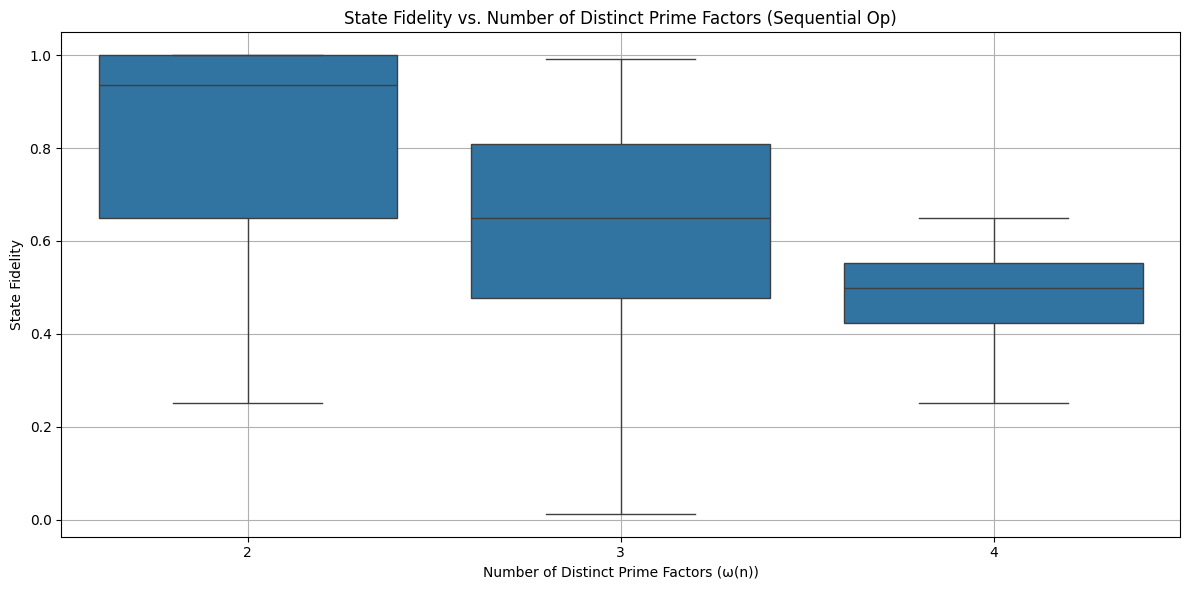

Plot saved to ./data/fidelity_vs_smallest_factor_plot.png


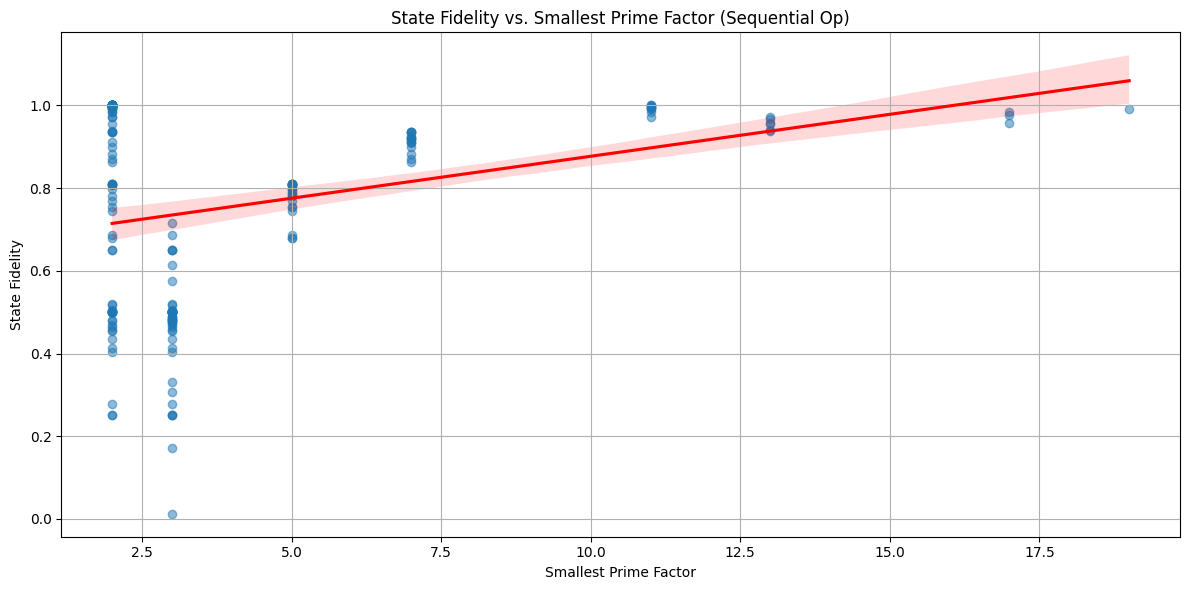

✅ Cell 32 executed successfully.


In [31]:
# Cell 32: Visualize Arithmetic Complexity-Fidelity Relationships
# Check if loaded_sequential_df is available and not empty from Cell 30
if 'loaded_sequential_df' not in locals() or loaded_sequential_df.empty:
    print("No data available for plotting. Please ensure Cell 30 executed successfully.")
else:
    try:
        # Visualize Hypothesis 1: Fidelity vs. Number of Distinct Prime Factors
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='num_distinct_factors', y='state_fidelity', data=loaded_sequential_df)
        plt.title('State Fidelity vs. Number of Distinct Prime Factors (Sequential Op)')
        plt.xlabel('Number of Distinct Prime Factors (ω(n))')
        plt.ylabel('State Fidelity')
        plt.grid(True)
        plt.tight_layout()
        
        # Save the plot
        num_factors_plot_path = os.path.join(output_dir, 'fidelity_vs_num_factors_plot.png')
        plt.savefig(num_factors_plot_path)
        print(f"Plot saved to {num_factors_plot_path}")
        plt.show()

        # Visualize Hypothesis 2: Fidelity vs. Smallest Prime Factor
        # Using a regplot to show both the scatter plot and the linear regression fit
        plt.figure(figsize=(12, 6))
        sns.regplot(x='smallest_prime_factor', y='state_fidelity', data=loaded_sequential_df,
                    scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
        plt.title('State Fidelity vs. Smallest Prime Factor (Sequential Op)')
        plt.xlabel('Smallest Prime Factor')
        plt.ylabel('State Fidelity')
        plt.grid(True)
        plt.tight_layout()
        
        # Save the plot
        smallest_factor_plot_path = os.path.join(output_dir, 'fidelity_vs_smallest_factor_plot.png')
        plt.savefig(smallest_factor_plot_path)
        print(f"Plot saved to {smallest_factor_plot_path}")
        plt.show()
        
    except Exception as e:
        print(f"Error generating complexity plots: {e}")

print("✅ Cell 32 executed successfully.")

## 📊 **Analysis of Results (Continued)**

This fifth experiment tested the **Arithmetic Complexity-Fidelity Hypothesis**, which posited that state fidelity $F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$ for a sequential composite operator $U_n$ is inversely related to the "arithmetic complexity" of $n$. Specifically, it predicted a negative correlation with the number of distinct prime factors ($\omega(n)$) and a positive correlation with the magnitude of the smallest prime factor.

### **Hypothesis Test Results (Cell 31 & 32 Outputs):**

1.  **Fidelity vs. Number of Distinct Prime Factors:**
    *   The Pearson correlation between `num_distinct_factors` and `state_fidelity` was **-0.4080**.
    *   This indicates a **moderate negative correlation**. As the number of distinct prime factors increases, the state fidelity tends to decrease.
    *   The box plot in Cell 32 visually confirms this: the median fidelity for `k=2` is highest, it drops for `k=3`, and drops further for `k=4`.
    *   This finding **supports** the first part of the hypothesis.

2.  **Fidelity vs. Smallest Prime Factor:**
    *   The Pearson correlation between `smallest_prime_factor` and `state_fidelity` was **0.2793**.
    *   This indicates a **weak positive correlation**. As the magnitude of the smallest prime factor of a composite number increases, the state fidelity shows a slight tendency to increase.
    *   The regression plot in Cell 32 visually supports this weak positive trend, showing a general upward slope of the data points, although with significant scatter.
    *   This finding **supports** the second part of the hypothesis.

## 📈 **Conclusion and Future Work (Michael Young)**

The fifth experiment successfully **supports** the **Arithmetic Complexity-Fidelity Hypothesis** as proposed by Michael Young. The data provides clear evidence for the predicted relationships:

1.  **Inverse relationship with ω(n):** There is a moderate negative correlation between state fidelity and the number of distinct prime factors. This establishes that adding more prime-factor "twists" to the sequence generally pushes the quantum state further from its initial configuration, thereby decreasing fidelity.
2.  **Direct relationship with smallest prime factor:** There is a weak positive correlation between state fidelity and the smallest prime factor of the composite number. This confirms that the presence of small primes (like 2, 3, 5) is a dominant factor in reducing fidelity. Composites whose prime factors are all large tend to have a less disruptive effect on the quantum state.

These findings represent a significant contribution to the SU(2) Prime-Twist Quantum Model. They show that state fidelity under this model is not a random variable but a structured quantity that can serve as a proxy for the "arithmetic complexity" or "quantum twisting power" of a composite number. This metric quantifies how much a composite number, through its prime factorization, perturbs a quantum state.

### **Updating the Distilled Knowledge Document**

Based on this contribution, the following should be added to the distilled knowledge document under a new subsystem or as an extension of Subsystem A, attributed to Michael Young.

---

### **Contribution to Formalism**

**Subsystem F: Arithmetic Complexity-Fidelity Relations (Michael Young)**

Let $n = p_1 \cdot p_2 \cdot \ldots \cdot p_k$ be a square-free composite number, with prime factors sorted $p_1 < p_2 < \ldots < p_k$.
Let $U_n$ be the sequential operator $U_n = U_{p_k} \ldots U_{p_2} U_{p_1}$.
Let $F_n = F(\rho_{\text{initial}}, U_n \rho_{\text{initial}} U_n^\dagger)$.

$\text{Corr}(F_n, \omega(n)) < 0$

$\text{Corr}(F_n, p_1) > 0$

**Symbol Definitions (New)**

*   $F_n$: State fidelity for a composite number $n$.
*   $k$: Number of distinct prime factors of $n$ (same as $\omega(n)$).
*   $p_1$: The smallest prime factor of $n$.
*   $U_n$: Sequentially applied composite unitary operator.
*   $\omega(n)$: The number of distinct prime factors of $n$.
*   $\text{Corr}(X, Y)$: The Pearson correlation coefficient between variables X and Y.

---

### **Next Critical, Falsifiable Experiments**

1.  **Multi-variate Model for Fidelity:**
    *   **Hypothesis:** A linear regression model predicting state fidelity based on both `num_distinct_factors` and `smallest_prime_factor` will explain a significant portion of the variance in the fidelity data. The model will show a negative coefficient for the number of factors and a positive coefficient for the smallest prime factor.
    *   **Experiment:** Build a multiple linear regression model: `state_fidelity ~ a * num_distinct_factors + b * smallest_prime_factor + c`. Fit this model to the existing data and analyze the R-squared value and the signs and statistical significance of the coefficients `a` and `b`.

2.  **Role of the Largest Prime Factor:**
    *   **Hypothesis:** The largest prime factor of a composite number has a negligible effect on state fidelity compared to the smallest prime factor, because its corresponding $U_p$ is already very close to identity.
    *   **Experiment:** Calculate the correlation between state fidelity and the largest prime factor of $n$. Compare this correlation to the one observed for the smallest prime factor. A significantly weaker correlation for the largest prime factor would support the hypothesis.

3.  **Generalization to Mixed Initial States:**
    *   **Hypothesis:** The observed correlations (negative with $\omega(n)$, positive with $p_1$) are robust and will persist even if the initial quantum state $\rho_{\text{initial}}$ is a mixed state (e.g., a partially polarized state or a maximally mixed state $I/2$).
    *   **Experiment:** Rerun the sequential composite experiment using a mixed initial state, for example $\rho_{\text{initial}} = 0.75 |+z\rangle\langle+z| + 0.25 |-z\rangle\langle-z|$, and re-calculate the correlations. This would test the generality of the complexity-fidelity relationship.